# Supplementary Notebook for
## "PIsToN: Evaluating Protein Binding Interfaces with Transformer Networks"

This notebook provides instructions on how to download and use the pre-trained PiSToN model.

 - <b>Part 1</b>: Downloading and reading the pre-trained PiSToN model
 - <b>Part 2</b>: Applying PIsToN to the MaSIF-test dataset [1]
 - <b>Part 3</b>: Exploring interpretability and attention values
 - <b>Part 4</b>: Applying PIsToN to the CAPRI score set [2]
 - <b>Part 5</b>: Applying PIsToN to the PDB-2023 set.

Preprocessing of custom protein structures can be obtained from us upon request.

### References:
[1] Gainza, P., Sverrisson, F., Monti, F., Rodola, E., Boscaini, D., Bronstein, M.M. and Correia, B.E., 2020. Deciphering interaction fingerprints from protein molecular surfaces using geometric deep learning. Nature Methods, 17(2), pp.184-192.

[2] Lensink, M.F. and Wodak, S.J., 2014. Score_set: a CAPRI benchmark for scoring protein complexes. Proteins: Structure, Function, and Bioinformatics, 82(11), pp.3163-3169.

### Author:
Vitalii Stebliankin (vsteb002@fiu.edu) <br>
Bioinformatics Research Group (BioRG) <br>
Florida International University


In [1]:
# !pip3 install tqdm
# !pip3 install einops
# !pip3 install keras-applications==1.0.8
# !pip3 install opencv-python==4.5.5.62
# !pip3 install pandas
# !pip3 install torch==1.10.1
# !pip3 install biopython --upgrade
# !pip3 install plotly
# !pip3 install torchsummary
# !pip3 install torchsummaryX
# !pip3 install scipy
# !pip3 install sklearn
# !pip3 install matplotlib
# !pip3 install seaborn
# !pip3 install ml_collections
# !pip3 install kaleido
# !pip3 install sklearn
# !pip3 install pdb2sql

# Part 1: Readng the PIsToN model

## Download datasets

In [2]:
# MaSIF-test
!wget https://zenodo.org/record/7948337/files/masif_test.tar.gz?download=1 -O ./data/masif_test.tar.gz
!wget https://zenodo.org/record/7948337/files/capri_score.tar.gz?download=1 -O ./data/capri_score.tar.gz
!wget https://zenodo.org/record/7948337/files/PDB_2023.tar.gz?download=1 -O ./data/PDB_2023.tar.gz

--2023-05-18 00:09:00--  https://zenodo.org/record/7532873/files/masif_test.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553438414 (528M) [application/octet-stream]
Saving to: ‘./data/masif_test.tar.gz’

./data/masif_test.t 100%[===================>] 527.80M   530KB/s    in 17m 12s 

2023-05-18 00:26:14 (524 KB/s) - ‘./data/masif_test.tar.gz’ saved [553438414/553438414]

--2023-05-18 00:26:14--  https://zenodo.org/record/7532873/files/capri_score.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2930171378 (2.7G) [application/octet-stream]
Saving to: ‘./data/capri_score.tar.gz’

ri_score.tar.gz      17%[==>                 ] 481.10M   533KB/s    eta 75m 51s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



./data/capri_score. 100%[===================>]   2.73G  3.97MB/s    in 51m 22s 

2023-05-18 01:17:39 (929 KB/s) - ‘./data/capri_score.tar.gz’ saved [2930171378/2930171378]

--2023-05-18 01:17:39--  https://zenodo.org/record/7532873/files/PDB_2023.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1101944060 (1.0G) [application/octet-stream]
Saving to: ‘./data/PDB_2023.tar.gz’

./data/PDB_2023.tar 100%[===================>]   1.03G  6.88MB/s    in 9m 58s  

2023-05-18 01:27:38 (1.76 MB/s) - ‘./data/PDB_2023.tar.gz’ saved [1101944060/1101944060]



In [3]:
!tar xf data/masif_test.tar.gz -C data/
!tar xf data/capri_score.tar.gz -C data/
!tar xf data/PDB_2023.tar.gz -C data/
!mv ./data/capri_score_copy/ ./data/capri_score
!mv ./data/masif_test_copy/ ./data/masif_test

## Reading the PIsToN model

In [4]:
import sys
# sys.path.append("..")

import torch
import numpy as np
from networks.PIsToN_multiAttn import PIsToN_multiAttn
from networks.ViT_pytorch import get_ml_config

MODEL_DIR='./saved_models/'
MODEL_NAME='PIsToN_multiAttn_contrast'

## Paremeters of the original training:
params = {'dim_head': 16,
          'hidden_size': 16,
          'dropout': 0,
          'attn_dropout': 0,
          'n_heads': 8,
          'patch_size': 4,
          'transformer_depth': 8}

#device=torch.device("cuda")
device=torch.device("cpu")

model_config=get_ml_config(params)
model = PIsToN_multiAttn(model_config, img_size=32,
                        num_classes=2).float().to(device)

model.load_state_dict(torch.load(MODEL_DIR + '/{}.pth'.format(MODEL_NAME), map_location=device))
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
n_params = sum([np.prod(p.size()) for p in model_parameters])

print(f"Loaded PiSToN model with {n_params} trainable parameters.")

Loaded PiSToN model with 92984 trainable parameters.


/lclhome/vsteb002/miniconda3/envs/svpy37/lib/python3.7/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


# Part 2: MaSIF test dataset

## Create the dataset object

In [5]:
import sys

from utils.dataset import PISToN_dataset
import os
import numpy as np

GRID_DIR = 'data/masif_test/prepare_energies_16R/07-grid/'
ppi_list = os.listdir(GRID_DIR)
ppi_list = [x.split('.npy')[0] for x in ppi_list if 'resnames' not in x and '.ref' not in x]

labels = [0 if 'neg' in x else 1 for x in ppi_list]


print(f"Extracted {len(ppi_list)} complexes.")
print(f"{np.sum(labels)} acceptable and {len(labels) -np.sum(labels) } incorrect.")
masif_test_dataset = PISToN_dataset(GRID_DIR, ppi_list)

Extracted 1356 complexes.
678 acceptable and 678 incorrect.
Interaction maps shape: (1356, 13, 32, 32)
All energies shape: (1356, 13)


### Visualize an example of interface map:

In [6]:
masif_test_dataset.vis_patch('1YY9-pos_A_D')

## Obtain scores and attention maps

In [7]:
from time import time
from torch.utils.data import DataLoader
from tqdm import tqdm

start = time()
torch.set_num_threads(1)
device=torch.device("cpu")

masif_test_loader = DataLoader(masif_test_dataset, batch_size=1, shuffle=False, pin_memory=False)

all_outputs = [] # output score
all_attn = [] # output attention map
predicted_labels = [] #predicted label (0 for negative and 1 for positive)

with torch.no_grad():
    for instance in tqdm(masif_test_loader):
        grid, all_energies = instance
        grid = grid.to(device)
        all_energies = all_energies.float().to(device)
        model = model.to(device)
        output, attn = model(grid, all_energies)
        all_outputs.append(output)
        all_attn.append(attn)
        if float(output)<0:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
            
output = torch.cat(all_outputs, axis=0)
print(f"Total inference time: {time() - start} sec")

output

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1356/1356 [00:31<00:00, 43.23it/s]

Total inference time: 31.383161783218384 sec


tensor([-1.8791,  0.8573, -1.0945,  ...,  1.2640,  1.9405,  1.8984])

## Plot ROC AUC and AUPRC

Final test AUC of PIsToN_multiAttn_contrast: 0.9355600804030595


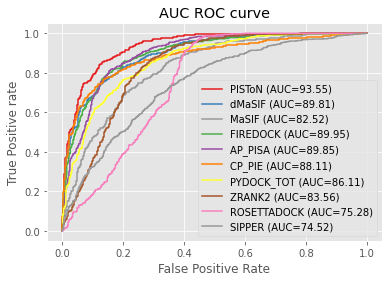

In [8]:
import torch.nn.functional as F
from sklearn import metrics
import pandas as pd


SCORES_MASIF="data/masif_test/MaSIF-Search_scores.csv"
OTHER_SCORES="data/masif_test/Other_tools_SCORES.csv"
dMASIF_SCORES="data/masif_test/dmasif_out.csv"

os.makedirs('figures', exist_ok=True)

def plot_ROC(df, score_name, label_name, model_name, ax, color, pos_label):
    fpr, tpr, thresh = roc_curve(df[label_name], df[score_name], pos_label=pos_label)
    AUC = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, linestyle='-',color=color, label=f'{model_name} (AUC={int(AUC*10000)/100})')

    
pred_probabilities = output.cpu().detach().numpy()
auc = metrics.roc_auc_score(labels, pred_probabilities)
print(f"Final test AUC of {MODEL_NAME}: {1-auc}")

## Save the file with all scores
all_ppis = ppi_list
out_file = f"{MODEL_DIR}/{MODEL_NAME}_scores.csv"
with open(out_file, 'w') as out:
    out.write("PPI,score,label\n")
    for i in range(len(pred_probabilities)):
        out.write(f"{all_ppis[i]},{pred_probabilities[i]},{labels[i]}\n")

scores_df = pd.read_csv(out_file)
scores_masif = pd.read_csv(SCORES_MASIF)
scores_other = pd.read_csv(OTHER_SCORES)
scores_dmasif = pd.read_csv(dMASIF_SCORES)

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

colors = matplotlib.cm.Set1(range(10))


fig, ax = plt.subplots()
plot_ROC(scores_df, 'score', 'label', 'PISToN', ax, colors[0], pos_label=0)
plot_ROC(scores_dmasif, 'avg_score', 'label', 'dMaSIF', ax, colors[1], pos_label=1)
plot_ROC(scores_masif, 'score', 'label', 'MaSIF', ax, colors[8], pos_label=0)

other_labels = ['FIREDOCK', 'AP_PISA', 'CP_PIE', 'PYDOCK_TOT', 'ZRANK2', 'ROSETTADOCK', 'SIPPER']
pos_label = [0,0,1,0,0,0,1]
colors_array = ['r', 'c', 'm', 'y', 'black', 'orange', 'tan']
for i in range(len(other_labels)):
    plot_ROC(scores_other, other_labels[i], 'Label', other_labels[i], ax, colors[i+2], pos_label=pos_label[i])



# # title
plt.title('AUC ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig(f'figures/out_AUC_{MODEL_NAME}.png',dpi=600)
plt.show();

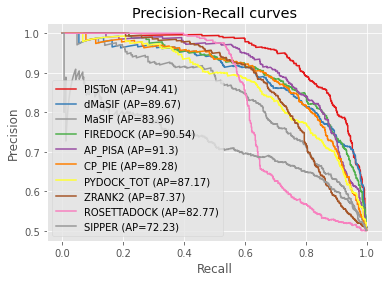

In [9]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

def plot_AUPRC(df, score_name, label_name, model_name, ax, color, reverse_sign=False):
    # Precision-Recall curve
    pred_scores = - df[score_name] if reverse_sign else df[score_name]
    precision, recall, thresholds = precision_recall_curve(df[label_name], pred_scores)
    AP = average_precision_score(df[label_name], pred_scores)
    ax.plot(recall, precision, linestyle='-',color=color, label=f'{model_name} (AP={int(AP*10000)/100})')      


fig, ax = plt.subplots()
plot_AUPRC(scores_df, 'score', 'label', 'PISToN', ax, colors[0], reverse_sign=1)
plot_AUPRC(scores_dmasif, 'avg_score', 'label', 'dMaSIF', ax, colors[1], reverse_sign=0)
plot_AUPRC(scores_masif, 'score', 'label', 'MaSIF', ax, colors[8], reverse_sign=1)

reverse_sign = [1,1,0,1,1,1,0]

for i in range(len(other_labels)):
    plot_AUPRC(scores_other, other_labels[i], 'Label', other_labels[i], ax, colors[i+2], reverse_sign=reverse_sign[i])

# # title
plt.title('Precision-Recall curves')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')

plt.legend(loc='best')
plt.savefig(f'figures/out_AUPRC_{MODEL_NAME}.png',dpi=600)
plt.show();

## Classification metrics


Even though protein scoring functions aim to distinguish native and decoy docking structures, evaluation of classification power is a non-trivial task. Establishing optimal classification threshold depends on the dataset distribution and the desired balance between true positives, false positives, false negatives, and true negatives. The classification threshold was chosen to maximize the Matthews correlation coefficient with 10-fold cross-validation on a test set, as proposed previously in the virtual screening application.


Reference:
https://www.pnas.org/doi/10.1073/pnas.2000585117



In [10]:
from sklearn.metrics import matthews_corrcoef, f1_score, balanced_accuracy_score, auc, precision_score, recall_score
import random

# def chunk(xs, n):
#     """
#     Randomly split a list into n chunks
#     """
#     ys = list(xs)
#     random.shuffle(ys)
#     ylen = len(ys)
#     size = int(ylen / n)
#     chunks = [ys[0+size*i : size*(i+1)] for i in xrange(n)]
#     leftover = ylen - size*n
#     edge = size*n
#     for i in xrange(leftover):
#             chunks[i%n].append(ys[edge+i])
#     return chunks

def find_threshold_one_fold(df, score_name, label_name):
    precision, recall, thresholds = precision_recall_curve(df[label_name], df[score_name])
    max_matthews = 0
    optimal_threshold = 0
    labels = df[label_name]
    for thr in thresholds:
        pred_labels = df[score_name].apply(lambda x: int(x>thr))
        matthews = matthews_corrcoef(labels, pred_labels)
        if matthews>max_matthews:
            max_matthews = matthews
            optimal_threshold = thr
    return optimal_threshold, max_matthews

def find_optimal_threshold(df, score_name, label_name, reverse_sign=True):
    """
    df - dataframe with binding scores
    score_name - column name with binding scores
    label name - column name with true labels
    if reverse_sign, than we assume that lower values represent the better score
    ----
    return: optimal threshold
    """
    df = df.copy()
    if reverse_sign:
        df[score_name] = - df[score_name]

    all_thresholds = []
    all_matthews = []
    shuffled = df.sample(frac=1, random_state=15)
    all_chunks = np.array_split(shuffled, 10)
    labels = df[label_name]
    for cv_df in all_chunks:
        cv_optimal, cv_matthews = find_threshold_one_fold(cv_df, score_name, label_name)
        all_thresholds.append(cv_optimal)
        all_matthews.append(cv_matthews)
        
    optimal_threshold = np.mean(all_thresholds)
    pred_labels = df[score_name].apply(lambda x: int(x>optimal_threshold))
    balanced_accuracy = balanced_accuracy_score(labels, pred_labels)
    f1 = f1_score(labels, pred_labels)
    precision = precision_score(labels, pred_labels)
    recall = recall_score(labels, pred_labels)
    
    if reverse_sign:
        all_thresholds = [-x for x in all_thresholds]
        optimal_threshold = np.mean(all_thresholds)

    print(f"Optimal threshold: {optimal_threshold}; BA={balanced_accuracy}, F1={f1}, Precision={precision}; Recall={recall}")
    return all_thresholds, all_matthews, [balanced_accuracy, f1, precision, recall]

all_results = []
all_thresholds = []
all_matthews = []
print("PIsToN")
thresholds, matthews, metrics = find_optimal_threshold(scores_df, 'score', 'label')
all_results.append(['PIsToN']+metrics)
all_thresholds.append(['PIsToN']+thresholds)
all_matthews.append(['PIsToN']+matthews)

print("")
print("dMaSIF")
thresholds, matthews, metrics = find_optimal_threshold(scores_dmasif, 'avg_score', 'label', reverse_sign=False)
all_results.append(['dMaSIF']+metrics)
all_thresholds.append(['dMaSIF']+thresholds)
all_matthews.append(['dMaSIF']+matthews)

print("")
print("MaSIF")
thresholds, matthews, metrics = find_optimal_threshold(scores_masif, 'score', 'label')
all_results.append(['MaSIF']+metrics)
all_thresholds.append(['MaSIF']+thresholds)
all_matthews.append(['MaSIF']+matthews)

for i in range(len(other_labels)):
    print("")
    print(other_labels[i])
    thresholds, matthews, metrics = find_optimal_threshold(scores_other, other_labels[i], 'Label', reverse_sign=reverse_sign[i])
    all_results.append([other_labels[i]]+metrics)
    all_thresholds.append([other_labels[i]]+thresholds)
    all_matthews.append([other_labels[i]]+matthews)
    
metrics_df = pd.DataFrame(all_results, columns=['Method','BA','F1', 'Precision', 'Recall'])
metrics_df.to_csv('classification_masif_test.csv', index=False)
metrics_df

PIsToN
Optimal threshold: 0.8454105138778687; BA=0.8525073746312685, F1=0.8459167950693375, Precision=0.885483870967742; Recall=0.8097345132743363

dMaSIF
Optimal threshold: 0.18779688701033592; BA=0.8134218289085545, F1=0.816, Precision=0.8048780487804879; Recall=0.827433628318584

MaSIF
Optimal threshold: 2.071556639671326; BA=0.749266862170088, F1=0.72508038585209, Precision=0.802491103202847; Recall=0.6612903225806451

FIREDOCK
Optimal threshold: -14.928; BA=0.8183256548863691, F1=0.8157503714710252, Precision=0.8280542986425339; Recall=0.8038067349926794

AP_PISA
Optimal threshold: -0.16376999999999997; BA=0.8198080316698368, F1=0.812785388127854, Precision=0.8462757527733756; Recall=0.7818448023426061

CP_PIE
Optimal threshold: 0.8183475999999998; BA=0.810296561229353, F1=0.7993803253292022, Precision=0.8486842105263158; Recall=0.7554904831625183

PYDOCK_TOT
Optimal threshold: -14.026900000000001; BA=0.7765582667462421, F1=0.7762289068231842, Precision=0.7779411764705882; Recall=

Method        BA        F1  Precision    Recall
0       PIsToN  0.852507  0.845917   0.885484  0.809735
1       dMaSIF  0.813422  0.816000   0.804878  0.827434
2        MaSIF  0.749267  0.725080   0.802491  0.661290
3     FIREDOCK  0.818326  0.815750   0.828054  0.803807
4      AP_PISA  0.819808  0.812785   0.846276  0.781845
5       CP_PIE  0.810297  0.799380   0.848684  0.755490
6   PYDOCK_TOT  0.776558  0.776229   0.777941  0.774524
7       ZRANK2  0.778855  0.743633   0.884848  0.641288
8  ROSETTADOCK  0.760591  0.698061   0.945000  0.553441
9       SIPPER  0.686406  0.703190   0.667984  0.742313

In [11]:
## optimal thresholds
thresholds_df = pd.DataFrame(all_thresholds, columns=['Method']+list(range(1,11)))
thresholds_df.to_csv('thresholds_masif_test.csv', index=False)
thresholds_df

Method          1          2           3          4           5  \
0       PIsToN   0.220163   0.405951    0.779436   1.424939    1.090225   
1       dMaSIF  -0.380442   0.209818    0.321854   0.295028    0.349755   
2        MaSIF   2.039356   1.926006    2.217310   1.883726    2.172627   
3     FIREDOCK -12.060000 -10.260000  -15.660000 -11.080000   -8.410000   
4      AP_PISA  -0.225700  -0.143500   -0.129600  -0.185500   -0.155100   
5       CP_PIE   0.951800   0.614134    0.836779   0.871953    0.809453   
6   PYDOCK_TOT -16.420000 -18.322000  -19.029000  -7.520000   -9.507000   
7       ZRANK2 -95.195100 -88.455100 -177.567000 -79.961500 -124.683000   
8  ROSETTADOCK  -3.468000  -2.363000   -2.093000  -2.564000   -2.715000   
9       SIPPER   1.314000  -0.102000    1.292000   0.187000    0.585000   

            6           7           8          9          10  
0    0.579931    1.022530    0.513423   1.099643    1.317865  
1   -0.062876    0.761233   -0.047861   0.481757   -0.050298  
2    2.181533    1.974291    2.066301   1.923109    2.331308  
3  -12.550000  -29.020000  -24.360000  -9.840000  -16.040000  
4   -0.145500   -0.128800   -0.218900  -0.176500   -0.128600  
5    0.747940    0.825216    1.009125   0.664521    0.852555  
6  -12.644000  -19.589000  -12.924000 -16.735000   -7.579000  
7 -124.500000 -134.389000 -157.105000 -98.810700 -122.727000  
8   -2.224000   -2.479000   -2.513000  -1.958000   -1.404000  
9    1.903000    5.594000   -1.429000   2.563000    5.717000

In [12]:
## best matthews correlation scores
matthews_df = pd.DataFrame(all_matthews, columns=['Method']+list(range(1,11)))
matthews_df.to_csv('matthews_masif_test.csv', index=False)
matthews_df

Method         1         2         3         4         5         6  \
0       PIsToN  0.734129  0.716332  0.717892  0.765692  0.878327  0.697705   
1       dMaSIF  0.594494  0.658702  0.691850  0.728574  0.556335  0.617997   
2        MaSIF  0.518770  0.585980  0.504906  0.459849  0.586395  0.690850   
3     FIREDOCK  0.679173  0.716267  0.886117  0.726907  0.629054  0.676203   
4      AP_PISA  0.722884  0.702303  0.694178  0.714268  0.679188  0.794966   
5       CP_PIE  0.710218  0.618838  0.627337  0.719411  0.635511  0.766234   
6   PYDOCK_TOT  0.640228  0.625873  0.630623  0.683121  0.524603  0.636247   
7       ZRANK2  0.663134  0.535108  0.584248  0.725929  0.629052  0.612613   
8  ROSETTADOCK  0.521984  0.514342  0.609957  0.550865  0.590932  0.655565   
9       SIPPER  0.442235  0.464007  0.534228  0.517398  0.421863  0.501340   

          7         8         9        10  
0  0.798857  0.817057  0.762295  0.781817  
1  0.661934  0.730986  0.688576  0.779230  
2  0.501410  0.586964  0.587953  0.552342  
3  0.615868  0.617869  0.652385  0.667669  
4  0.702297  0.648672  0.722902  0.627332  
5  0.661101  0.590366  0.645777  0.671944  
6  0.683289  0.548195  0.501299  0.598317  
7  0.634400  0.547899  0.663996  0.669534  
8  0.618384  0.672382  0.589022  0.655857  
9  0.471511  0.355732  0.308558  0.490187

# Distribution of scores

Classify docked complexes as "high", "medium", "acceptable", and "incorrect" CAPRI labels.

In [13]:
# ## for each model get corresponding iRMSD
# import os
# import sys
# sys.path.append('..')
# from utils.utils import merge_chains
# from pdb2sql import StructureSimilarity


# TEST_DPB_DIR = os.getcwd() + '/data/masif_test/PDB/'
# ORIGINAL_DPB_DIR = os.getcwd() + '/data/masif_test/ORIGINAL_PDB/'

# #all_docked_ppis = os.listdir(all_docked_dir)
# GRID_DIR = 'data/masif_test/prepare_energies_16R/07-grid/'

# ppi_list = os.listdir(GRID_DIR)
# ppi_model_list = [x.split('.npy')[0] for x in ppi_list if 'resnames' not in x and '.ref' not in x]

# masif_list_original = [x.strip('\n') for x in open('./data/lists/masif_test_original.txt').readlines()]

# #pid_list = [x.split('-')[0] for x in ppi_model_list]

# tmp_dir = os.environ.get('HOME') + '/tmp/'

# print(tmp_dir)
# all_irmsd = []
# all_lrmsd = []
# all_fnat = []

# for ppi in ppi_model_list:
#     pid = ppi.split('-')[0]
#     pid_model, ch1, ch2 = ppi.split('_')
#     # print(f"Computing iRMSD for {pid_model}...")
    
#     if 'model' not in pid_model:
#         irmsd = 0
#         lrmsd = 0
#         fnat = 1
#     else:
        
    
#         # get original ppi
#         for ppi_tmp in masif_list_original:
#             pid_tmp = ppi_tmp.split('_')[0]
#             if pid_tmp==pid:
#                 original_ppi = ppi_tmp
#                 break

#         pid, ch1_original, ch2_original = original_ppi.split('_')
#         pdb_model_path = f"{TEST_DPB_DIR}/{pid_model}.pdb"
#         pdb_original_path = f"{ORIGINAL_DPB_DIR}/{pid}_{ch1_original}_{ch2_original}.pdb"
        
#         sim = StructureSimilarity(pdb_model_path, pdb_original_path)
#         irmsd = sim.compute_irmsd_pdb2sql(method='svd')
#         lrmsd = sim.compute_lrmsd_pdb2sql(method='svd')
#         fnat = sim.compute_fnat_pdb2sql()
#     all_irmsd.append(irmsd)
#     all_lrmsd.append(lrmsd)
#     all_fnat.append(fnat)
#     #print(f"iRMSD: {irmsd}; lRMSD: {lrmsd}; FNAT: {fnat}")
    
#     #print(reference_pdb)
   


In [14]:
# capri_labels_dict = {"PPI":ppi_model_list, "iRMSD":all_irmsd, "lRMSD":all_lrmsd, "FNAT":all_fnat}
# scores_df = pd.DataFrame(capri_labels_dict)

# def access_capri_quality(irmsd, lrmsd, fnat):
#     if fnat>=0.5 and (lrmsd<=1 or irmsd<=1):
#         return 1 # high quality
#     elif (fnat >= 0.5 and lrmsd > 1 and irmsd>1) or (fnat >= 0.3 and fnat<0.5 and lrmsd<=5 and irmsd<=2):
#         return 2
#     elif (fnat<0.1) or (lrmsd>10 and irmsd>4):
#         return 4
#     else:
#         return 3

# scores_df['CAPRI_quality'] = scores_df.apply(lambda x: access_capri_quality(x['iRMSD'], x['lRMSD'], x['FNAT']), axis=1)
# scores_df = scores_df[["PPI", "CAPRI_quality", "iRMSD", "lRMSD", "FNAT"]]
# scores_df.to_csv("./data/masif_test/capri_quality_masif_test.csv", index=False)

In [15]:
scores_df = pd.read_csv("./data/masif_test/capri_quality_masif_test.csv")

piston_score_df = pd.DataFrame({"PIsToN_score": output.cpu(), "PPI": all_ppis})
scores_df = scores_df.merge(piston_score_df, how='left', on="PPI")

scores_df

PPI  CAPRI_quality   iRMSD   lRMSD      FNAT  \
0      3CHW-model-1-pos_A_Z              1   0.081   0.184  0.947368   
1     1YOX-model-70-neg_A_Z              4  10.933  19.859  0.000000   
2      1JK9-model-1-pos_A_Z              1   0.269   0.543  0.906977   
3     1TZS-model-20-neg_A_Z              4  10.867  36.535  0.000000   
4     2QBX-model-98-neg_A_Z              4   4.798  16.365  0.035088   
...                     ...            ...     ...     ...       ...   
1351   1R7A-model-6-neg_A_Z              4  35.789  88.685  0.000000   
1352   3U1O-model-1-pos_A_Z              2   1.473   7.228  0.870968   
1353  1ERN-model-16-neg_A_Z              4  16.169  45.201  0.000000   
1354  3DSN-model-66-neg_A_Z              4  17.429  49.832  0.000000   
1355  4V0N-model-92-neg_A_Z              4  17.227  58.722  0.000000   

      PIsToN_score  
0        -1.879070  
1         0.857257  
2        -1.094475  
3         0.076614  
4         1.693276  
...            ...  
1351      1.822176  
1352      1.464292  
1353      1.263981  
1354      1.940549  
1355      1.898367  

[1356 rows x 6 columns]

In [16]:
# limit to processed ppi list
scores_df['PID'] = scores_df['PPI'].apply(lambda x: x.split("-")[0])

ppi_list = [x.strip('\n') for x in open('./data/lists/masif_test_original.txt')]
pid_list = [x.split('_')[0] for x in ppi_list if x.split('_')[0] in list(scores_df['PID'])]
ppi_list = [x for x in ppi_list if x.split('_')[0] in pid_list]
print(len(ppi_list))

678


In [17]:
import torch
import numpy as np
import sys

from networks.PIsToN_multiAttn import PIsToN_multiAttn
from networks.ViT_pytorch import get_ml_config

from utils.dataset import PISToN_dataset
import os
import numpy as np

GRID_DIR='./data/masif_test/prepare_energies_16R_native/07-grid/'

masif_test_native = PISToN_dataset(GRID_DIR, ppi_list)

## obtain scores
from torch.utils.data import DataLoader
from tqdm import tqdm

masif_test_loader = DataLoader(masif_test_native, batch_size=1, shuffle=False, pin_memory=False)

all_outputs = [] # output score
all_attn_native = [] # output attention map
predicted_labels_native = []

with torch.no_grad():
    for instance in tqdm(masif_test_loader):
        grid, all_energies = instance
        grid = grid.to(device)
        all_energies = all_energies.float().to(device)
        model = model.to(device)
        output, attn = model(grid, all_energies)
        all_outputs.append(output)
        all_attn_native.append(attn)
        if float(output)<0:
            predicted_labels_native.append(1)
        else:
            predicted_labels_native.append(0)

output = torch.cat(all_outputs, axis=0)
output = output.cpu()


Interaction maps shape: (678, 13, 32, 32)
All energies shape: (678, 13)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [00:15<00:00, 43.51it/s]


In [18]:
# concatenate with scores_df

scores_df = scores_df[['CAPRI_quality', 'PIsToN_score', 'PPI']]
scores_df_native = pd.DataFrame({'CAPRI_quality': [0]*len(output), 'PIsToN_score':output, 'PPI':ppi_list})
scores_df = pd.concat([scores_df, scores_df_native], ignore_index=True)


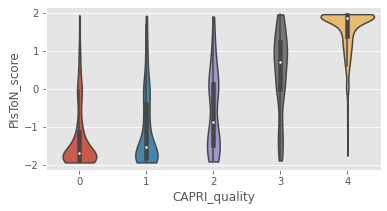

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#sns.set_style('whitegrid')
plt.subplots(figsize=(6, 3))

# sns.kdeplot(data=scores_df, x='PIsToN_score', hue='CAPRI_quality', fill=True)
# #sns.despine()
# plt.show()
gfg = sns.violinplot(data=scores_df, x='CAPRI_quality', y='PIsToN_score', cut=0)
plt.savefig('./figures/violin_MaSIF_test_PiSTON.png',dpi=600)

# Part 3 - Attention Values

## 1. Feature attention

In [20]:
def output_feature_attention(attn):
    spatial_attn, feature_attn = attn
    att_mat = feature_attn
    att_mat = torch.stack(att_mat).squeeze(1)
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1).cpu()
    #att_mat = att_mat[-1]
    
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    final_attn = v[0, 1:]/v[0, 1:].sum()
    return final_attn

In [21]:

attn_dict = {'attn':[], 'feature':[], 'label':[], 'pred_label':[], 'PPI':[], 'misclassified':[]}

for i, attn_i in tqdm(enumerate(all_attn)):
    feature_att = output_feature_attention(attn_i)
    attn_dict['attn'].append(float(feature_att[0].cpu()))
    attn_dict['attn'].append(float(feature_att[1].cpu()))
    attn_dict['attn'].append(float(feature_att[2].cpu()))
    attn_dict['attn'].append(float(feature_att[3].cpu()))
    attn_dict['attn'].append(float(feature_att[4].cpu()))
    
    attn_dict['feature'].append('geometric')
    attn_dict['feature'].append('RASA')
    attn_dict['feature'].append('HB')
    attn_dict['feature'].append('charge')
    attn_dict['feature'].append('hydropathy')
    
    for j in range(5):
        attn_dict['label'].append(labels[i])
        attn_dict['pred_label'].append(predicted_labels[i])
        attn_dict['PPI'].append(masif_test_dataset.ppi_list[i])
        attn_dict['misclassified'].append(labels[i]!=predicted_labels[i])
        
# Attention of native complexes
for i, attn_i in tqdm(enumerate(all_attn_native)):
    feature_att = output_feature_attention(attn_i)
    attn_dict['attn'].append(float(feature_att[0].cpu()))
    attn_dict['attn'].append(float(feature_att[1].cpu()))
    attn_dict['attn'].append(float(feature_att[2].cpu()))
    attn_dict['attn'].append(float(feature_att[3].cpu()))
    attn_dict['attn'].append(float(feature_att[4].cpu()))
    
    attn_dict['feature'].append('geometric')
    attn_dict['feature'].append('RASA')
    attn_dict['feature'].append('HB')
    attn_dict['feature'].append('charge')
    attn_dict['feature'].append('hydropathy')
    
    for j in range(5):
        attn_dict['label'].append(1)
        attn_dict['pred_label'].append(predicted_labels_native[i])
        attn_dict['PPI'].append(masif_test_native.ppi_list[i])
        attn_dict['misclassified'].append(predicted_labels_native[i]!=predicted_labels_native[i])
            
    
import pandas as pd
attn_df_test = pd.DataFrame(attn_dict)
attn_df_test

1356it [00:00, 8577.31it/s]
678it [00:00, 8604.53it/s]


attn     feature  label  pred_label                   PPI  \
0      0.225589   geometric      1           1  3CHW-model-1-pos_A_Z   
1      0.220580        RASA      1           1  3CHW-model-1-pos_A_Z   
2      0.176693          HB      1           1  3CHW-model-1-pos_A_Z   
3      0.204092      charge      1           1  3CHW-model-1-pos_A_Z   
4      0.173046  hydropathy      1           1  3CHW-model-1-pos_A_Z   
...         ...         ...    ...         ...                   ...   
10165  0.218651   geometric      1           1              1S98_A_B   
10166  0.208151        RASA      1           1              1S98_A_B   
10167  0.179111          HB      1           1              1S98_A_B   
10168  0.204947      charge      1           1              1S98_A_B   
10169  0.189140  hydropathy      1           1              1S98_A_B   

       misclassified  
0              False  
1              False  
2              False  
3              False  
4              False  
...              ...  
10165          False  
10166          False  
10167          False  
10168          False  
10169          False  

[10170 rows x 6 columns]

In [22]:
## Merge with CAPRI labels
attn_df_test = attn_df_test.merge(scores_df, on="PPI", how='left')
attn_df_test


attn     feature  label  pred_label                   PPI  \
0      0.225589   geometric      1           1  3CHW-model-1-pos_A_Z   
1      0.220580        RASA      1           1  3CHW-model-1-pos_A_Z   
2      0.176693          HB      1           1  3CHW-model-1-pos_A_Z   
3      0.204092      charge      1           1  3CHW-model-1-pos_A_Z   
4      0.173046  hydropathy      1           1  3CHW-model-1-pos_A_Z   
...         ...         ...    ...         ...                   ...   
10165  0.218651   geometric      1           1              1S98_A_B   
10166  0.208151        RASA      1           1              1S98_A_B   
10167  0.179111          HB      1           1              1S98_A_B   
10168  0.204947      charge      1           1              1S98_A_B   
10169  0.189140  hydropathy      1           1              1S98_A_B   

       misclassified  CAPRI_quality  PIsToN_score  
0              False              1      -1.87907  
1              False              1      -1.87907  
2              False              1      -1.87907  
3              False              1      -1.87907  
4              False              1      -1.87907  
...              ...            ...           ...  
10165          False              0      -1.68463  
10166          False              0      -1.68463  
10167          False              0      -1.68463  
10168          False              0      -1.68463  
10169          False              0      -1.68463  

[10170 rows x 8 columns]

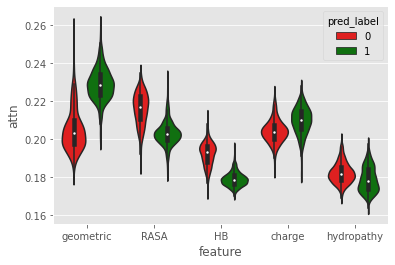

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
my_pal = {"acceptable": 'tab:green', "incorrect": 'tab:red',}
sns.violinplot(data=attn_df_test,x='feature', y='attn', hue='pred_label',palette=['r','g'])
plt.savefig(f'./figures/feature_attn.png',dpi=600)


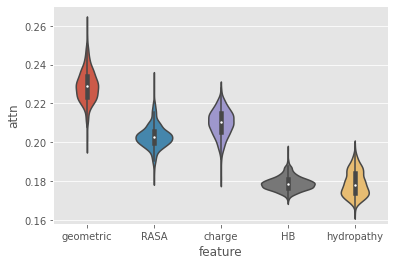

In [24]:
# Attention values for complexes predicted as "acceptable":
attn_df_test_pos = attn_df_test[attn_df_test['pred_label']==1]
sns.violinplot(data=attn_df_test_pos, x='feature', y='attn', order=[ "geometric", "RASA", "charge", "HB", "hydropathy"])
plt.ylim(0.158,0.27), 
plt.savefig(f'figures/feature_attn_pos.png',dpi=600)

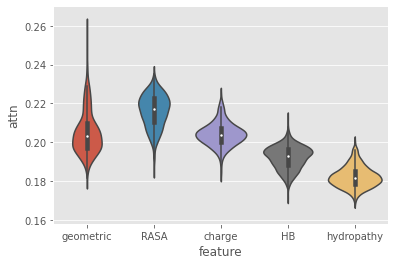

In [25]:
# Attention values for complexes predicted as "incorrect":
attn_df_test_neg = attn_df_test[attn_df_test['pred_label']==0]
sns.violinplot(data=attn_df_test_neg, x='feature', y='attn', order=[ "geometric", "RASA", "charge", "HB", "hydropathy"])
plt.ylim(0.158,0.27)
plt.savefig(f'./figures/feature_attn_neg.png',dpi=600)


## 2. Spatial attention

### 2.1. Obtain distribution of attention values from training set


In [27]:
## Distribution of attention values

def get_spatial_attn(att_mat):
    """
    Given a multihead attention map, output normalized attention.
    """
    att_mat = torch.stack(att_mat).squeeze(1)
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1).cpu()
    #att_mat = att_mat[-1]

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).cpu()
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    final_attn = v[0, 1:]/v[0, 1:].sum()

    # final_attn = final_attn/final_attn.max()
    # final_attn = final_attn.reshape([8,8])
    # final_attn
    return final_attn.detach().numpy()

import numpy as np

# Initialize dictionary of all pixel values for each feature type
all_spatial_attn_dict = {"geometry":[], "RASA":[], "HB":[], "charge":[], "hydropathy":[]}
for example_i in range(len(all_attn)):
    spatial_attn, feature_attn = all_attn[example_i]
    for feature_i in range(len(all_spatial_attn_dict.keys())):
        att_mat = spatial_attn[feature_i]
        final_attn = get_spatial_attn(att_mat)
        all_spatial_attn_dict[list(all_spatial_attn_dict.keys())[feature_i]] += list(final_attn)

# Compute mean and SD for each feature:
stat_spatial_attn_dict = dict()
for feature_i in range(len(all_spatial_attn_dict.keys())):
    feature = list(all_spatial_attn_dict.keys())[feature_i]
    stat_spatial_attn_dict[feature]=dict()
    stat_spatial_attn_dict[feature]['mean'] = np.mean(all_spatial_attn_dict[feature])
    stat_spatial_attn_dict[feature]['std'] = np.std(all_spatial_attn_dict[feature])

stat_spatial_attn_dict   

{'geometry': {'mean': 0.015625, 'std': 0.0013559808},
 'RASA': {'mean': 0.015625, 'std': 0.0019012161},
 'HB': {'mean': 0.015625, 'std': 0.0015596547},
 'charge': {'mean': 0.015625, 'std': 0.002948854},
 'hydropathy': {'mean': 0.015625, 'std': 0.0019812644}}

### Pair the native and negative examples 

In [28]:
score_df = attn_df_test[['PPI', 'CAPRI_quality','PIsToN_score']].drop_duplicates()
score_df['PID'] = score_df['PPI'].apply(lambda x: x.split('-')[0] if '-' in x else x.split('_')[0])

score_df_native = score_df[score_df['CAPRI_quality']==0]
score_df_native["PIsToN_native"] = score_df_native['PIsToN_score']
score_df_native["PPI_native"] = score_df_native['PPI']
score_df_native = score_df_native[['PPI_native', 'PID','PIsToN_native']]

score_df_incorrect = score_df[score_df['CAPRI_quality']==4]
score_df_incorrect["PIsToN_incorrect"] = score_df_incorrect['PIsToN_score']
score_df_incorrect["PPI_neg"] = score_df_incorrect['PPI']
score_df_incorrect = score_df_incorrect[['PPI_neg','PID','PIsToN_incorrect']]

score_df = score_df_native.merge(score_df_incorrect, how='left', on='PID')
score_df['diff'] = score_df['PIsToN_incorrect'] - score_df['PIsToN_native']
score_df = score_df.sort_values(by='diff', ascending=False)
score_df

/lclhome/vsteb002/miniconda3/envs/svpy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/lclhome/vsteb002/miniconda3/envs/svpy37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/lclhome/vsteb002/miniconda3/envs/svpy37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

PPI_native   PID  PIsToN_native                PPI_neg  PIsToN_incorrect  \
283   1U20_A_B  1U20      -1.926860  1U20-model-36-neg_A_Z          1.962386   
463   2IQH_A_C  2IQH      -1.924229   2IQH-model-9-neg_A_Z          1.961368   
244   4KFZ_A_C  4KFZ      -1.921587  4KFZ-model-24-neg_A_Z          1.962178   
92    3DCL_A_B  3DCL      -1.928512  3DCL-model-69-neg_A_Z          1.954599   
52    2Z29_A_B  2Z29      -1.909729  2Z29-model-68-neg_A_Z          1.963238   
..         ...   ...            ...                    ...               ...   
615   1VGO_A_B  1VGO       1.931654  1VGO-model-57-neg_A_Z          1.786693   
392   3CDW_A_H  3CDW       0.367937  3CDW-model-69-neg_A_Z          0.220163   
3     2VE6_A_D  2VE6       0.741052  2VE6-model-20-neg_A_Z          0.553999   
328   3PGA_1_4  3PGA      -1.200487   3PGA-model-8-neg_A_Z         -1.756896   
490   3JVC_A_C  3JVC       0.956095  3JVC-model-69-neg_A_Z          0.225400   

         diff  
283  3.889246  
463  3.885597  
244  3.883765  
92   3.883111  
52   3.872967  
..        ...  
615 -0.144961  
392 -0.147774  
3   -0.187053  
328 -0.556409  
490 -0.730695  

[678 rows x 6 columns]

### Visualize spatial attention on MaSIF-test set

In [29]:
## function to identify significant pixels
import cv2

def get_significant_pixels(ppi, grid_dir, spatial_attn, stat_spatial_attn_dict):
    all_significant_pixels = []
    resnames = f"{grid_dir}/{ppi}_resnames.npy"
    resnames = np.load(resnames, allow_pickle=True)
    for feature_i in range(len(stat_spatial_attn_dict.keys())):
        feature = list(stat_spatial_attn_dict.keys())[feature_i]
        att_mat = spatial_attn[feature_i]
        final_attn = get_spatial_attn(att_mat)
        z_scores = (final_attn-stat_spatial_attn_dict[feature]['mean'])/stat_spatial_attn_dict[feature]['std']
        mask = z_scores>1.96#2.58
        significant_minipatches = (mask*final_attn)/final_attn.max()
        significant_minipatches = significant_minipatches.reshape((8,8))
        significant_pixels = cv2.resize(significant_minipatches, dsize=(resnames.shape[0],resnames.shape[1]))
        all_significant_pixels.append(significant_pixels)
    return all_significant_pixels

from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly


def vis_patch(grid_dir, ppi, col_i, html_path=None, attn=None, fig=None):
    feature_pairs = {
        'shape_index': (0, 5),
        'ddc': (1, 6),
        'electrostatics': (2, 7),
        'charge': (3, 8),
        'hydrophobicity': (4, 9),
        'RASA': (11, 12),
        'patch_dist': (10,),
    }
    resnames_path = grid_dir + '/' + ppi + '_resnames.npy'
    patch_path = grid_dir + '/' + ppi + '.npy'
    patch_np = np.load(patch_path, allow_pickle=True)

    patch_resnames = np.load(resnames_path, allow_pickle=True)
    # patch_resnames = patch_resnames[:,:,0]
    n_feat = int(patch_np.shape[-1] / 2)
    key_names = list(feature_pairs.keys())
    if fig is None:
        fig = make_subplots(2, 6)

    patch_dist = patch_np[:, :, feature_pairs['patch_dist']].reshape((patch_np.shape[0], patch_np.shape[1]))
    patch_dist = np.round(patch_dist, 2)
    for row_i, pair_i in enumerate(feature_pairs[key_names[col_i]]):
        patch_i = patch_np[:, :, pair_i]
        if attn is not None:
            #mask = (attn+0.01)*(attn==0) + attn
            mask = (attn>0) * attn
            patch_i = patch_i * mask

        customdata = np.stack([patch_resnames[:, :, row_i], patch_dist], axis=-1)

        fig.add_trace(go.Heatmap(
            z=patch_i,
            customdata=customdata,
            hovertemplate='<b>Value:%{z:.3f}</b><br>Amino Acid:%{customdata[0]}; dist:%{customdata[1]}',
            name='',
            colorscale='RdBu',
            zmid=0,
            showscale=False,
            showlegend=False
        )
            ,
            row_i + 1, col_i+1)
    fig.update_layout(
        title_text='The interactive patch pair for {}. Hover to see the value and corresponding amino acid name.'.format(
            ppi))
    return fig
    
    
def vis_attention(ppi, GRID_DIR, all_significant_pixels):
    print("Shape Index")
    # attention geometry
    fig = vis_patch(GRID_DIR, ppi, 0, attn=all_significant_pixels[0])

    print("Curvature")
    # attention geometry
    fig = vis_patch(GRID_DIR, ppi, 1, attn=all_significant_pixels[0], fig=fig)

    print("HB")
    fig =vis_patch(GRID_DIR, ppi, 2, attn=all_significant_pixels[2], fig=fig)

    print("Charge")
    fig =vis_patch(GRID_DIR, ppi, 3, attn=all_significant_pixels[3], fig=fig)

    print("Hydropathy")
    fig =vis_patch(GRID_DIR, ppi, 4, attn=all_significant_pixels[4],fig=fig)

    print("RASA")
    fig =vis_patch(GRID_DIR, ppi, 5, attn=all_significant_pixels[1], fig=fig)
    fig.write_html(f"figures/attention_plots/{ppi}.html")
    fig.show()

if not os.path.exists('figures/attention_plots'):
    os.mkdir('figures/attention_plots')
    

In [30]:
def plot_attn(masif_test_dataset, ppi, all_attn):
    ppi_idx = masif_test_dataset.ppi_list.index(ppi)
    ppi = masif_test_dataset.ppi_list[ppi_idx]
    grid_dir = masif_test_dataset.grid_dir
    spatial_attn = all_attn[ppi_idx][0]
    print(f"Testing for {ppi}")
    all_significant_pixels = get_significant_pixels(ppi, grid_dir, spatial_attn, stat_spatial_attn_dict)
    vis_attention(ppi, grid_dir, all_significant_pixels)

### Identify only significant features from feature attention

In [31]:
# Compute mean and SD for each feature:
stat_feature_attn_dict = dict()

for feature in tqdm(attn_df_test['feature'].unique()):
    stat_feature_attn_dict[feature]=dict()
    tmp_df = attn_df_test[attn_df_test['feature']==feature]
    stat_feature_attn_dict[feature]['mean'] = tmp_df['attn'].mean()
    stat_feature_attn_dict[feature]['std'] = tmp_df['attn'].std()
stat_feature_attn_dict

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1050.68it/s]


{'geometric': {'mean': 0.2173072404522108, 'std': 0.015482364942751618},
 'RASA': {'mean': 0.20949948159290976, 'std': 0.009811756684439486},
 'HB': {'mean': 0.1854766803256061, 'std': 0.008198344865886574},
 'charge': {'mean': 0.2071965695189398, 'std': 0.00713043878814997},
 'hydropathy': {'mean': 0.18052003024221053, 'std': 0.0062161615907478165}}

### Iterate though each complex and plot attention if value is significan


In [32]:
for index, row in score_df.iterrows():
    ppi_native, ppi_neg = row['PPI_native'], row['PPI_neg']
    
    signif_feat_pos = []
    signif_feat_neg = []
    attention_dict_pos = {}
    attention_dict_neg = {}
    for feature in attn_df_test['feature'].unique():
        tmp_df = attn_df_test[attn_df_test['feature']==feature]
        tmp_df_neg = tmp_df[tmp_df['PPI']==ppi_neg].reset_index(drop=True)
        tmp_df_pos = tmp_df[tmp_df['PPI']==ppi_native].reset_index(drop=True)
        
        attn_neg = tmp_df_neg.loc[0,:]['attn']
        attn_pos = tmp_df_pos.loc[0,:]['attn']
        
        zscore_neg = (attn_neg-stat_feature_attn_dict[feature]['mean'])/stat_feature_attn_dict[feature]['std']
        zscore_pos = (attn_pos-stat_feature_attn_dict[feature]['mean'])/stat_feature_attn_dict[feature]['std']
        
        if zscore_neg>1.96:
            signif_feat_neg.append(feature)
        if zscore_pos>1.96:
            signif_feat_pos.append(feature)
            
        attention_dict_pos[feature] = attn_pos#zscore_pos#attn_pos
        attention_dict_neg[feature] = attn_neg#zscore_neg#attn_neg
            
    score_native = row['PIsToN_native']
    score_incorrect = row['PIsToN_incorrect']
    
    if len(signif_feat_pos)>0 and len(signif_feat_neg)>0:
        print(f"{row['PPI_native']}: {signif_feat_pos} {row['PPI_neg']}: {signif_feat_neg}; score native: {score_native}; score incorrect: {score_incorrect}")
        print(f"attn pos: {attention_dict_pos}; attn neg: {attention_dict_neg}")
        print("")


1J3R_A_B: ['hydropathy'] 1J3R-model-89-neg_A_Z: ['RASA']; score native: -1.9108330011367798; score incorrect: 1.9450314044952393
attn pos: {'geometric': 0.22133712470531464, 'RASA': 0.20016980171203613, 'HB': 0.18646927177906036, 'charge': 0.1984706073999405, 'hydropathy': 0.19355307519435883}; attn neg: {'geometric': 0.1923036128282547, 'RASA': 0.23041881620883942, 'HB': 0.2010871171951294, 'charge': 0.2002640664577484, 'hydropathy': 0.17592643201351166}

3BFW_C_D: ['hydropathy'] 3BFW-model-47-neg_A_Z: ['RASA']; score native: -1.9019430875778198; score incorrect: 1.8626455068588257
attn pos: {'geometric': 0.21704484522342682, 'RASA': 0.2039090245962143, 'HB': 0.1806628257036209, 'charge': 0.20529140532016754, 'hydropathy': 0.1930919587612152}; attn neg: {'geometric': 0.18868488073349, 'RASA': 0.23015131056308746, 'HB': 0.1967129409313202, 'charge': 0.20416776835918427, 'hydropathy': 0.1802830845117569}

2OYA_A_B: ['charge'] 2OYA-model-78-neg_A_Z: ['HB']; score native: -1.8392958641052

In [33]:
# Visualize the first significant complex

## Positive
masif_test_native.vis_patch("1J3R_A_B", html_path='./figures/1J3R_A_B-whole.html')


In [34]:
## Negative

masif_test_dataset.vis_patch("1J3R-model-89-neg_A_Z", html_path='./figures/1J3R-model-89-neg_A_-whole.html')


#### Create the PyMol plot

In [35]:
from collections import defaultdict

#### 1J3R_A_B

ppi_idx = masif_test_native.ppi_list.index("1J3R_A_B")
ppi = masif_test_native.ppi_list[ppi_idx]
grid_dir = masif_test_native.grid_dir
spatial_attn = all_attn_native[ppi_idx][0]
print(f"Testing for {ppi}")
all_significant_pixels = get_significant_pixels(ppi, grid_dir, spatial_attn, stat_spatial_attn_dict)
resnames_path = grid_dir + '/' + ppi + '_resnames.npy'
resnames = np.load(resnames_path, allow_pickle=True)

for i, significant_pixels in enumerate(all_significant_pixels):
    feature = list(stat_spatial_attn_dict.keys())[i]
    all_significant_res = set()
    for i in range(resnames.shape[0]):
        for j in range(resnames.shape[1]):
            if significant_pixels[i][j]>0:
                all_significant_res.add(resnames[i][j][0])
                all_significant_res.add(resnames[i][j][1])

    all_significant_res = set([x.split('-')[0] for x in all_significant_res if x!=0])

    ## Generate pymol selection string
    chains_dict = defaultdict(list)
    for res in all_significant_res:
        #ch = res.split(':')[0]
        #atom_indx = res.split('-')[1].split(':')[0]
        ch, resi, resname = res.split(':')
        chains_dict[ch].append(resi)
        #chains_dict[ch].append(atom_indx)

    ## select
    pymol_string=f"select {feature},"
    for ch in chains_dict.keys():
        pymol_string += f" (chain {ch} and resi {','.join(chains_dict[ch])}) or"
        #pymol_string += f" (chain {ch} and index {','.join(chains_dict[ch])}) or"
    pymol_string = pymol_string.strip('or')
    print(pymol_string)
#     print(chains_dict)

        

Testing for 1J3R_A_B
select geometry, (chain A and resi 153,68,155,69,156,152,99,98,65,97,130,66,154,67) or (chain B and resi 60,98,7,130,97,99,153,67,154,66,69,152,150,65) 
select RASA, (chain A and resi 11,7,58,13,9,69,103,101) or (chain B and resi 128,150,126,11,101,103,13) 
select HB, (chain A and resi 4,7,58,9,69,66,60,67) or (chain B and resi 150,9,69,18,11,101,7,103,13) 
select charge,
select hydropathy, (chain A and resi 11,152,150,69,18,101) or (chain B and resi 128,99,101,152) 


# Part 3: CAPRI score set

The interface images were created based on the following dataset:

https://data.sbgrid.org/dataset/843/

## Read the CAPRI dataset

In [36]:
from utils.dataset import PISToN_dataset
import os
import numpy as np


def get_processed(ppi_list, GRID_DIR):
    """
    Output processed protein complexes.
    For a small number of the models, interaction maps failed to preprocess, possibly due to clashes.
    The PIsToN scores for those models will be assigned to "incorrect"
    """
    processed_ppis = []
    for ppi in ppi_list:
        pid, ch1, ch2 = ppi.split('_')
        if os.path.exists(GRID_DIR + '/' + ppi + '.npy'):
            processed_ppis.append(ppi)
    return processed_ppis


CAPRI_DIR = 'data/capri_score/'
GRID_DIR = CAPRI_DIR+'piston_prepare/07-grid/'
CAPRI_LIST_FILE = CAPRI_DIR + 'capri_list_models.txt'

capri_list = [x.strip('\n') for x in open(CAPRI_LIST_FILE, 'r').readlines()]
test_list_updated = get_processed(capri_list, GRID_DIR)

print(f"{len(test_list_updated)}/{len(capri_list)} complexes were processed.")
unprocessed_complexes = set(capri_list) - set(test_list_updated)

print(f"Unprocessed complexes: {unprocessed_complexes}")
print("The PISToN score for those complexes will be assigned to 2 (because smaller number is a better complex).")

unique_pids = list(set([x.split('-')[0] for x in capri_list]))

print(f"Unique targets: {unique_pids}")

capri_dataset = PISToN_dataset(GRID_DIR, test_list_updated)

16581/16585 complexes were processed.
Unprocessed complexes: {'T37-401_A_B', 'T37-1239_A_B', 'T37-919_A_B', 'T37-515_A_B'}
The PISToN score for those complexes will be assigned to 2 (because smaller number is a better complex).
Unique targets: ['T41', 'T32', 'T39', 'T30', 'T47', 'T54', 'T50', 'T53', 'T37', 'T35', 'T29', 'T40', 'T46']
Interaction maps shape: (16581, 13, 32, 32)
All energies shape: (16581, 13)


In [37]:
def read_score_dict(data_dir, score_file_affix, unique_pids, print_labels=False):
    """
    Read the scores file performed by DeepRank
    """
    score_dict = {}
    statistics_dict={"Sample":[], "N_pos":[], "N_neg":[]}
    for pid in unique_pids:
        score_file = f"{data_dir}/{pid}/{pid}.{score_file_affix}"
        all_scores = []
        for line in open(score_file).readlines():
            curr_model, score = line.strip('\n').split('\t')
            model_id = curr_model.split('_')[0] + '-' + curr_model.split('_')[1]
            score = float(score)
            score_dict[model_id] = score
            all_scores.append(score)
        if print_labels:
            print(f"Sample {pid}: {int(np.sum(all_scores))} positives out of {len(all_scores)} models")
            statistics_dict['Sample'].append(pid)
            statistics_dict['N_pos'].append(int(np.sum(all_scores)))
            statistics_dict['N_neg'].append(len(all_scores) - int(np.sum(all_scores)))
    if print_labels:
        df=pd.DataFrame(statistics_dict)
        df.to_csv("capri_dataset.csv")

    return score_dict

labels_dict = read_score_dict(CAPRI_DIR, 'label', unique_pids, print_labels=True) # true labels
dove_dict = read_score_dict(CAPRI_DIR, 'dove', unique_pids) # DOVE scores
deeprank_dict = read_score_dict(CAPRI_DIR, 'deeprank', unique_pids) # DeepRank scores
haddockScore_dict = read_score_dict(CAPRI_DIR, 'haddockScore', unique_pids) # HADDOCK scores
iScore_dict = read_score_dict(CAPRI_DIR, 'iScore', unique_pids) # iScore scores
capri_dict = read_score_dict(CAPRI_DIR, 'capri', unique_pids) # true capri qualities

# assign integer label
for key_i in labels_dict.keys():
    labels_dict[key_i] = int(labels_dict[key_i])
    
# Create labels array
labels = []
for ppi in test_list_updated:
    model_id = ppi.split('_')[0]
    labels.append(labels_dict[model_id])
    
print(f"Total {np.sum(labels)} positive complexes out of {len(labels)}")

Sample T41: 347 positives out of 1096 models
Sample T32: 15 positives out of 599 models
Sample T39: 4 positives out of 1287 models
Sample T30: 2 positives out of 1096 models
Sample T47: 608 positives out of 1015 models
Sample T54: 19 positives out of 1304 models
Sample T50: 133 positives out of 1447 models
Sample T53: 122 positives out of 1360 models
Sample T37: 97 positives out of 1364 models
Sample T35: 3 positives out of 497 models
Sample T29: 166 positives out of 1979 models
Sample T40: 535 positives out of 1971 models
Sample T46: 24 positives out of 1570 models
Total 2075 positive complexes out of 16581


## Inference

In [38]:
capri_loader = DataLoader(capri_dataset, batch_size=128, shuffle=False, pin_memory=False)

from tqdm import tqdm
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device=torch.device("cpu")

# Infer in batches
all_outputs = []
with torch.no_grad():
    for grid, all_energies in tqdm(capri_loader):
        grid = grid.to(device)
        all_energies = all_energies.float().to(device)
        model = model.to(device)
        output, attn = model(grid, all_energies)
        all_outputs.append(output)
output = torch.cat(all_outputs, axis=0)
output

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [02:07<00:00,  1.02it/s]


tensor([ 0.2456,  0.9261,  1.9602,  ...,  0.2290, -0.6003,  0.7949])

## Compute AUC

In [40]:
import torch.nn.functional as F
from sklearn import metrics

# pred_probabilities = F.softmax(output, dim=1)
pred_probabilities = list(output.cpu().detach().numpy())

# Select probability of the complex to be positive (y=1)
#pred_probabilities = [float(x[1]) for x in output]

# append unprocessed complexes
pred_probabilities = pred_probabilities + [1 for x in list(unprocessed_complexes)]
all_capri_complexes = test_list_updated + list(unprocessed_complexes)
true_labels = labels + [labels_dict[x.split('_')[0]] for x in list(unprocessed_complexes)]

def assign_score(score_dict, all_capri_complexes):
    score = []
    for ppi in all_capri_complexes:
        model_id = ppi.split('_')[0]
        score.append(score_dict[model_id])
    return score
        
dove_scores = assign_score(dove_dict, all_capri_complexes)
deeprank_scores = assign_score(deeprank_dict, all_capri_complexes)
haddockScore_scores = assign_score(haddockScore_dict, all_capri_complexes)
iScore_scores = assign_score(iScore_dict, all_capri_complexes)
scores_dmasif = pd.read_csv(dMASIF_SCORES)

capri_dict = read_score_dict(CAPRI_DIR, 'capri', unique_pids) 
capri_labels = assign_score(capri_dict, all_capri_complexes)

import pandas as pd

df = {"PISToN":pred_probabilities, 
      "DOVE": dove_scores, 
      "DeepRank": deeprank_scores, 
      "iSCORE": iScore_scores, 
      "HADDOCK": haddockScore_scores,
      "label": true_labels,
      "capri_quality": capri_labels,
     "model_name": all_capri_complexes,
     #"target": 
     }

df = pd.DataFrame(df)
df['target'] = df['model_name'].apply(lambda x: x.split('-')[0])
df['pid'] = df['model_name'].apply(lambda x: x.split('_')[0])
df

PISToN    DOVE  DeepRank  iSCORE    HADDOCK  label  capri_quality  \
0      0.245602  0.0031  0.093072  -0.453  -66.65310      0            4.0   
1      0.926115  0.2474  0.242705  -0.568  -65.60780      0            4.0   
2      1.960213  0.0617  0.992702   0.116  -76.41506      0            4.0   
3      1.523465  0.0062  0.154322  -0.292    9.46515      0            4.0   
4      1.959803  0.0125  0.992147  -0.680  -50.94296      0            4.0   
...         ...     ...       ...     ...        ...    ...            ...   
16580  0.794902  0.0453  1.000000   0.339  242.38618      0            4.0   
16581  1.000000  0.1598  1.000000   0.966  854.35735      0            4.0   
16582  1.000000  0.1457  0.972651  -0.808  -59.38579      0            4.0   
16583  1.000000  0.0035  0.999965   0.174  237.10611      0            4.0   
16584  1.000000  0.0068  0.999997  -0.436  697.20496      0            4.0   

         model_name target       pid  
0         T29-0_A_B    T29     T29-0  
1      T29-1000_A_B    T29  T29-1000  
2      T29-1001_A_B    T29  T29-1001  
3      T29-1002_A_B    T29  T29-1002  
4      T29-1003_A_B    T29  T29-1003  
...             ...    ...       ...  
16580     T54-9_A_B    T54     T54-9  
16581   T37-401_A_B    T37   T37-401  
16582  T37-1239_A_B    T37  T37-1239  
16583   T37-919_A_B    T37   T37-919  
16584   T37-515_A_B    T37   T37-515  

[16585 rows x 10 columns]

## Read scores from DeepRank-GNN

Reference: Réau, Manon, et al. "DeepRank-GNN: a graph neural network framework to learn patterns in protein–protein interfaces." Bioinformatics 39.1 (2023): btac759.



In [41]:
#!wget https://raw.githubusercontent.com/DeepRank/Deeprank-GNN/master/paper_pretrained_models/scoring_of_docking_models/BM5_CAPRI_datasets_details_csv/CAPRI_scores_targets.csv -O ./data/capri_score/CAPRI_scores_targets.csv

In [42]:
df_deepRank = pd.read_csv('./data/capri_score/CAPRI_scores_targets.csv')
df_deepRank['pid'] = df_deepRank['model'].apply(lambda x: x.split('_')[0] + '-' + x.split('_')[1])
df_deepRank = df_deepRank[['pid', 'DeepRank_GNN', 'GNN_DOVE']]
df_deepRank

pid  DeepRank_GNN  GNN_DOVE
0         T29-0      0.002169    0.1912
1      T29-1000      0.033626    0.2214
2      T29-1001      0.005455    0.0960
3      T29-1002     -0.000208    0.5877
4      T29-1003      0.013418    0.1148
...         ...           ...       ...
16575   T54-997      0.018442    0.0604
16576   T54-998      0.020574    0.0921
16577   T54-999      0.335369    0.1111
16578    T54-99      0.034720    0.1426
16579     T54-9      0.090515    0.0603

[16580 rows x 3 columns]

In [43]:
df = df.merge(df_deepRank, on='pid', how='right')
df

PISToN    DOVE  DeepRank  iSCORE    HADDOCK  label  capri_quality  \
0      0.245602  0.0031  0.093072  -0.453  -66.65310      0            4.0   
1      0.926115  0.2474  0.242705  -0.568  -65.60780      0            4.0   
2      1.960213  0.0617  0.992702   0.116  -76.41506      0            4.0   
3      1.523465  0.0062  0.154322  -0.292    9.46515      0            4.0   
4      1.959803  0.0125  0.992147  -0.680  -50.94296      0            4.0   
...         ...     ...       ...     ...        ...    ...            ...   
16575 -1.656684  0.0060  0.046907  -0.232  -61.96156      0            4.0   
16576  1.632490  0.0000  0.802730  -0.270  -70.93820      0            4.0   
16577  0.229003  0.0350  0.042973  -0.917 -124.79480      0            4.0   
16578 -0.600340  0.0001  0.299241   0.137  -87.61076      0            4.0   
16579  0.794902  0.0453  1.000000   0.339  242.38618      0            4.0   

         model_name target       pid  DeepRank_GNN  GNN_DOVE  
0         T29-0_A_B    T29     T29-0      0.002169    0.1912  
1      T29-1000_A_B    T29  T29-1000      0.033626    0.2214  
2      T29-1001_A_B    T29  T29-1001      0.005455    0.0960  
3      T29-1002_A_B    T29  T29-1002     -0.000208    0.5877  
4      T29-1003_A_B    T29  T29-1003      0.013418    0.1148  
...             ...    ...       ...           ...       ...  
16575   T54-997_A_B    T54   T54-997      0.018442    0.0604  
16576   T54-998_A_B    T54   T54-998      0.020574    0.0921  
16577   T54-999_A_B    T54   T54-999      0.335369    0.1111  
16578    T54-99_A_B    T54    T54-99      0.034720    0.1426  
16579     T54-9_A_B    T54     T54-9      0.090515    0.0603  

[16580 rows x 12 columns]

In [44]:
## Merge with dMaSIF

dMASIF_SCORES = './data/capri_score/dmasif_out.csv'
df_dmasif = pd.read_csv(dMASIF_SCORES)
df_dmasif['dMaSIF'] = df_dmasif['avg_score']
df_dmasif['pid'] = df_dmasif['PPI'].apply(lambda x: x.split('_')[0])
df_dmasif = df_dmasif[['pid', 'dMaSIF']]
df = df.merge(df_dmasif, on='pid', how='left')
df

PISToN    DOVE  DeepRank  iSCORE    HADDOCK  label  capri_quality  \
0      0.245602  0.0031  0.093072  -0.453  -66.65310      0            4.0   
1      0.926115  0.2474  0.242705  -0.568  -65.60780      0            4.0   
2      1.960213  0.0617  0.992702   0.116  -76.41506      0            4.0   
3      1.523465  0.0062  0.154322  -0.292    9.46515      0            4.0   
4      1.959803  0.0125  0.992147  -0.680  -50.94296      0            4.0   
...         ...     ...       ...     ...        ...    ...            ...   
16575 -1.656684  0.0060  0.046907  -0.232  -61.96156      0            4.0   
16576  1.632490  0.0000  0.802730  -0.270  -70.93820      0            4.0   
16577  0.229003  0.0350  0.042973  -0.917 -124.79480      0            4.0   
16578 -0.600340  0.0001  0.299241   0.137  -87.61076      0            4.0   
16579  0.794902  0.0453  1.000000   0.339  242.38618      0            4.0   

         model_name target       pid  DeepRank_GNN  GNN_DOVE    dMaSIF  
0         T29-0_A_B    T29     T29-0      0.002169    0.1912 -0.582117  
1      T29-1000_A_B    T29  T29-1000      0.033626    0.2214 -0.051979  
2      T29-1001_A_B    T29  T29-1001      0.005455    0.0960 -0.599100  
3      T29-1002_A_B    T29  T29-1002     -0.000208    0.5877 -0.499630  
4      T29-1003_A_B    T29  T29-1003      0.013418    0.1148 -0.917829  
...             ...    ...       ...           ...       ...       ...  
16575   T54-997_A_B    T54   T54-997      0.018442    0.0604 -1.798892  
16576   T54-998_A_B    T54   T54-998      0.020574    0.0921 -2.228157  
16577   T54-999_A_B    T54   T54-999      0.335369    0.1111  0.376598  
16578    T54-99_A_B    T54    T54-99      0.034720    0.1426 -3.087996  
16579     T54-9_A_B    T54     T54-9      0.090515    0.0603 -2.687755  

[16580 rows x 13 columns]

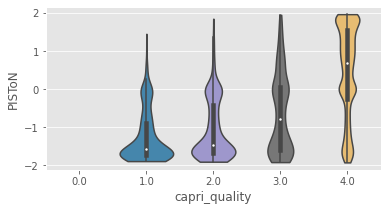

In [45]:
df_tmp = df.append({"PISToN":None, 
      "DOVE": None, 
      "DeepRank": None, 
      "iSCORE": None, 
      "HADDOCK": None,
     "DeepRank_GNN": None,
    "GNN_DOVE":None,
        "dMaSIF": None,
      "label": None,
      "capri_quality": 0,
     "model_name": None,}, ignore_index=True)

## Violin plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#sns.set_style('whitegrid')
plt.subplots(figsize=(6, 3))

# sns.kdeplot(data=scores_df, x='PIsToN_score', hue='CAPRI_quality', fill=True)
# #sns.despine()
# plt.show()
gfg = sns.violinplot(data=df_tmp, x='capri_quality', y='PISToN', cut=0)
plt.savefig('./figures/violin_CAPRI_PiSTON.png',dpi=600)


## Plot AUC

PISToN
dMaSIF
iSCORE
DeepRank_GNN
DeepRank
HADDOCK
GNN_DOVE
DOVE


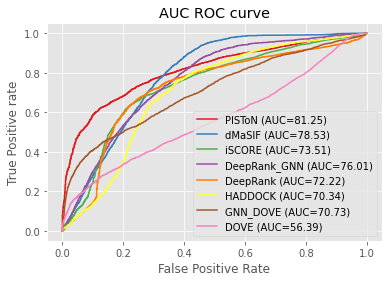

In [46]:
def plot_ROC(df, score_name, label_name, model_name, ax, color, pos_label):
    fpr, tpr, thresh = roc_curve(df[label_name], df[score_name].fillna(0), pos_label=pos_label)
    AUC = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, linestyle='-',color=color, label=f'{model_name} (AUC={int(AUC*10000)/100})')

    # matplotlib
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

colors = matplotlib.cm.Set1(range(9))

fig, ax = plt.subplots()

other_labels = ['PISToN', 'dMaSIF', 'iSCORE', 'DeepRank_GNN', 'DeepRank', 'HADDOCK', 'GNN_DOVE', 'DOVE']
pos_labels = [0,1,0,1,0,0,1,1]
colors_array = ['r', 'c', 'm', 'y', 'black']
for i in range(len(other_labels)):
    print(other_labels[i])
    plot_ROC(df, other_labels[i], 'label', other_labels[i], ax, colors[i], pos_label=pos_labels[i])



# # title
plt.title('AUC ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig(f'figures/AUC_CAPRI_{MODEL_NAME}.png',dpi=600)
plt.show();

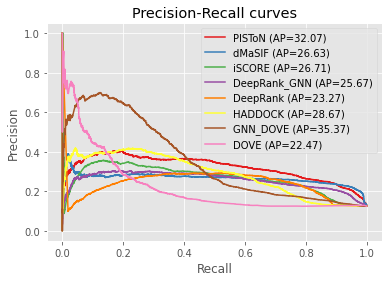

In [47]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

def plot_AUPRC(df, score_name, label_name, model_name, ax, color, reverse_sign=False):
    # Precision-Recall curve
    pred_scores = - df[score_name].fillna(0) if reverse_sign else df[score_name].fillna(0)
    precision, recall, thresholds = precision_recall_curve(df[label_name], pred_scores)
    AP = average_precision_score(df[label_name], pred_scores)
    ax.plot(recall, precision, linestyle='-',color=color, label=f'{model_name} (AP={int(AP*10000)/100})')      

fig, ax = plt.subplots()
other_labels = ['PISToN','dMaSIF', 'iSCORE', 'DeepRank_GNN', 'DeepRank', 'HADDOCK', 'GNN_DOVE', 'DOVE']
reverse_sign = [1,0,1,0,1,1,0,0]
colors_array = ['r', 'c', 'm', 'y', 'black']
for i in range(len(other_labels)):
    plot_AUPRC(df, other_labels[i], 'label', other_labels[i], ax, colors[i], reverse_sign=reverse_sign[i])


# # title
plt.title('Precision-Recall curves')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')

plt.legend(loc='best')
plt.savefig(f'figures/out_CAPRI_AUPRC_{MODEL_NAME}.png',dpi=600)
plt.show();

In [48]:
df

PISToN    DOVE  DeepRank  iSCORE    HADDOCK  label  capri_quality  \
0      0.245602  0.0031  0.093072  -0.453  -66.65310      0            4.0   
1      0.926115  0.2474  0.242705  -0.568  -65.60780      0            4.0   
2      1.960213  0.0617  0.992702   0.116  -76.41506      0            4.0   
3      1.523465  0.0062  0.154322  -0.292    9.46515      0            4.0   
4      1.959803  0.0125  0.992147  -0.680  -50.94296      0            4.0   
...         ...     ...       ...     ...        ...    ...            ...   
16575 -1.656684  0.0060  0.046907  -0.232  -61.96156      0            4.0   
16576  1.632490  0.0000  0.802730  -0.270  -70.93820      0            4.0   
16577  0.229003  0.0350  0.042973  -0.917 -124.79480      0            4.0   
16578 -0.600340  0.0001  0.299241   0.137  -87.61076      0            4.0   
16579  0.794902  0.0453  1.000000   0.339  242.38618      0            4.0   

         model_name target       pid  DeepRank_GNN  GNN_DOVE    dMaSIF  
0         T29-0_A_B    T29     T29-0      0.002169    0.1912 -0.582117  
1      T29-1000_A_B    T29  T29-1000      0.033626    0.2214 -0.051979  
2      T29-1001_A_B    T29  T29-1001      0.005455    0.0960 -0.599100  
3      T29-1002_A_B    T29  T29-1002     -0.000208    0.5877 -0.499630  
4      T29-1003_A_B    T29  T29-1003      0.013418    0.1148 -0.917829  
...             ...    ...       ...           ...       ...       ...  
16575   T54-997_A_B    T54   T54-997      0.018442    0.0604 -1.798892  
16576   T54-998_A_B    T54   T54-998      0.020574    0.0921 -2.228157  
16577   T54-999_A_B    T54   T54-999      0.335369    0.1111  0.376598  
16578    T54-99_A_B    T54    T54-99      0.034720    0.1426 -3.087996  
16579     T54-9_A_B    T54     T54-9      0.090515    0.0603 -2.687755  

[16580 rows x 13 columns]

## Success rate

In [49]:
import numpy as np

all_targets = list(df['target'].unique())


def compute_success_rate(method, ascending):
    top1 = 0
    top10 = 0
    top25 = 0
    top100= 0
    top200 = 0
    for target in all_targets:
        target_df = df[df['target']==target]
        target_df = target_df.sort_values(by=method, ascending=ascending).reset_index(drop=True)
        if 1 in list(target_df[:1]['label']):
             top1+=1
        if 1 in list(target_df[:10]['label']):
            top10+=1
        if 1 in list(target_df[:25]['label']):
            top25+=1
        if 1 in list(target_df[:100]['label']):
             top100+=1
        if 1 in list(target_df[:200]['label']):
            top200+=1
    all_success_rate = [top1, top10, top25, top100, top200]
    #all_success_rate = [top10, top25, top200]

    all_success_rate = [int(x*100/len(all_targets)) for x in all_success_rate]
#     print(method)
#     print(all_success_rate)
    #print(f"Top1: {all_success_rate[0]} Top10: {all_success_rate[1]}; Top25: {all_success_rate[[2]]}; Top100: {all_success_rate[3]}; Top200: {all_success_rate[4]}")
    return all_success_rate


#compute_success_rate('PISToN', True)
methods = ['PISToN', 'dMaSIF', 'iSCORE', 'DeepRank_GNN', 'DeepRank', 'HADDOCK', 'GNN_DOVE', 'DOVE']
all_scores = []
for method in methods:
    if method=='DeepRank_GNN' or method=='GNN_DOVE' or method=='DOVE' or method=='dMaSIF':
        all_scores.append([method]+compute_success_rate(method, False))
    else:
        all_scores.append([method]+compute_success_rate(method, True))

df_top = pd.DataFrame(all_scores, columns=['model','top1', 'top10', 'top25', 'top100', 'top200'])
df_top


model  top1  top10  top25  top100  top200
0        PISToN    38     69     76      76     100
1        dMaSIF    15     38     53      76      92
2        iSCORE    38     53     61      76      84
3  DeepRank_GNN    23     46     53      69      84
4      DeepRank    15     53     61      69      92
5       HADDOCK    23     46     53      69      76
6      GNN_DOVE    15     61     69      76     100
7          DOVE     7     38     61      76      84

## Other classification metrics

accuracy, precision, F1-score, and recall

In [50]:
df['target'] = df['model_name'].apply(lambda x: x.split('-')[0])
df

PISToN    DOVE  DeepRank  iSCORE    HADDOCK  label  capri_quality  \
0      0.245602  0.0031  0.093072  -0.453  -66.65310      0            4.0   
1      0.926115  0.2474  0.242705  -0.568  -65.60780      0            4.0   
2      1.960213  0.0617  0.992702   0.116  -76.41506      0            4.0   
3      1.523465  0.0062  0.154322  -0.292    9.46515      0            4.0   
4      1.959803  0.0125  0.992147  -0.680  -50.94296      0            4.0   
...         ...     ...       ...     ...        ...    ...            ...   
16575 -1.656684  0.0060  0.046907  -0.232  -61.96156      0            4.0   
16576  1.632490  0.0000  0.802730  -0.270  -70.93820      0            4.0   
16577  0.229003  0.0350  0.042973  -0.917 -124.79480      0            4.0   
16578 -0.600340  0.0001  0.299241   0.137  -87.61076      0            4.0   
16579  0.794902  0.0453  1.000000   0.339  242.38618      0            4.0   

         model_name target       pid  DeepRank_GNN  GNN_DOVE    dMaSIF  
0         T29-0_A_B    T29     T29-0      0.002169    0.1912 -0.582117  
1      T29-1000_A_B    T29  T29-1000      0.033626    0.2214 -0.051979  
2      T29-1001_A_B    T29  T29-1001      0.005455    0.0960 -0.599100  
3      T29-1002_A_B    T29  T29-1002     -0.000208    0.5877 -0.499630  
4      T29-1003_A_B    T29  T29-1003      0.013418    0.1148 -0.917829  
...             ...    ...       ...           ...       ...       ...  
16575   T54-997_A_B    T54   T54-997      0.018442    0.0604 -1.798892  
16576   T54-998_A_B    T54   T54-998      0.020574    0.0921 -2.228157  
16577   T54-999_A_B    T54   T54-999      0.335369    0.1111  0.376598  
16578    T54-99_A_B    T54    T54-99      0.034720    0.1426 -3.087996  
16579     T54-9_A_B    T54     T54-9      0.090515    0.0603 -2.687755  

[16580 rows x 13 columns]

In [51]:
all_results = []
all_thresholds = []
all_matthews = []
df = df.dropna()

for i in range(len(methods)):
    print("")
    print(methods[i])
    if methods[i] == 'DeepRank_GNN' or methods[i]=='GNN_DOVE' or methods[i]=='DOVE' or methods[i]=='dMaSIF':
        thresholds, matthews, metrics = find_optimal_threshold(df, methods[i], 'label', reverse_sign=False)
    else:
        thresholds, matthews, metrics = find_optimal_threshold(df, methods[i], 'label', reverse_sign=True)
    all_results.append([other_labels[i]]+metrics)
    all_thresholds.append([other_labels[i]]+thresholds)
    all_matthews.append([other_labels[i]]+matthews)
    
metrics_df = pd.DataFrame(all_results, columns=['Method','BA','F1', 'Precision', 'Recall'])
metrics_df.to_csv('classification_capri_test.csv', index=False)
metrics_df


PISToN
Optimal threshold: -0.35105338096618655; BA=0.7355292224228074, F1=0.41969653592900086, Precision=0.2979069294858769; Recall=0.7099273607748184

dMaSIF
Optimal threshold: -0.050440662447363116; BA=0.7379981391555421, F1=0.376312473750525, Precision=0.24024668186083925; Recall=0.8677966101694915

iSCORE
Optimal threshold: -0.1153; BA=0.6983652826287257, F1=0.3657951244158141, Precision=0.24743677375256323; Recall=0.7012106537530266

DeepRank_GNN
Optimal threshold: 0.13295053504407403; BA=0.6946681014163578, F1=0.35971400394477315, Precision=0.24127666611542914; Recall=0.7065375302663438

DeepRank
Optimal threshold: 0.05540579999999999; BA=0.705718899322891, F1=0.38472222222222224, Precision=0.2697176241480039; Recall=0.6707021791767555

HADDOCK
Optimal threshold: -120.2830658; BA=0.6620297668152306, F1=0.3786865906409753, Precision=0.3187686196623635; Recall=0.4663438256658596

GNN_DOVE
Optimal threshold: 0.61579; BA=0.6305556987775611, F1=0.3804580152671756, Precision=0.5148760

Method        BA        F1  Precision    Recall
0        PISToN  0.735529  0.419697   0.297907  0.709927
1        dMaSIF  0.737998  0.376312   0.240247  0.867797
2        iSCORE  0.698365  0.365795   0.247437  0.701211
3  DeepRank_GNN  0.694668  0.359714   0.241277  0.706538
4      DeepRank  0.705719  0.384722   0.269718  0.670702
5       HADDOCK  0.662030  0.378687   0.318769  0.466344
6      GNN_DOVE  0.630556  0.380458   0.514876  0.301695
7          DOVE  0.550094  0.192120   0.426667  0.123971

In [52]:
## optimal thresholds
thresholds_df = pd.DataFrame(all_thresholds, columns=['Method']+list(range(1,11)))
thresholds_df.to_csv('thresholds_capri.csv', index=False)
## best matthews correlation scores
matthews_df = pd.DataFrame(all_matthews, columns=['Method']+list(range(1,11)))
matthews_df.to_csv('matthews_capri.csv', index=False)


In [53]:
thresholds_df

Method           1           2           3           4           5  \
0        PISToN    0.010481    0.057458   -0.119417   -0.179849   -0.393092   
1        dMaSIF   -0.267037   -0.236158    0.003982    0.039880   -0.116007   
2        iSCORE    0.005000    0.063000   -0.079000   -0.153000   -0.304000   
3  DeepRank_GNN    0.053624    0.149527    0.248884    0.036997    0.170688   
4      DeepRank    0.063654    0.051858    0.076391    0.054233    0.037511   
5       HADDOCK -130.696300 -136.184400 -141.174500 -142.928200 -107.413368   
6      GNN_DOVE    0.638600    0.678900    0.691600    0.443700    0.674700   
7          DOVE    0.356400    0.769700    0.783400    0.477600    0.380000   

            6           7          8          9          10  
0   -0.430547   -0.712338  -0.707342  -0.119350   -0.916536  
1    0.275085   -0.103832  -0.150563   0.146076   -0.095832  
2   -0.025000    0.080000  -0.278000  -0.060000   -0.402000  
3    0.143816    0.038958   0.039671   0.136619    0.310722  
4    0.053385    0.063295   0.048322   0.062809    0.042600  
5 -101.086860 -104.519420 -89.514420 -95.564530 -153.748660  
6    0.608100    0.618400   0.566000   0.588600    0.649300  
7    0.507200    0.405900   0.805100   0.430700    0.442800

In [54]:
matthews_df

Method         1         2         3         4         5         6  \
0        PISToN  0.377390  0.321543  0.386824  0.340625  0.381263  0.350083   
1        dMaSIF  0.352983  0.304799  0.344149  0.335982  0.334871  0.334806   
2        iSCORE  0.321170  0.259354  0.296615  0.277498  0.322923  0.292941   
3  DeepRank_GNN  0.327672  0.286719  0.330591  0.250896  0.309783  0.273492   
4      DeepRank  0.356922  0.268414  0.306245  0.278641  0.330153  0.294774   
5       HADDOCK  0.350642  0.305617  0.301664  0.312988  0.326516  0.315995   
6      GNN_DOVE  0.411446  0.323616  0.358323  0.312786  0.395926  0.314671   
7          DOVE  0.183674  0.215770  0.176099  0.159661  0.218596  0.264249   

          7         8         9        10  
0  0.352535  0.327552  0.354457  0.384342  
1  0.331860  0.322813  0.327413  0.308253  
2  0.290007  0.302287  0.276389  0.272287  
3  0.310502  0.255426  0.291324  0.261391  
4  0.308388  0.301542  0.294477  0.342116  
5  0.311170  0.254607  0.256761  0.285063  
6  0.385238  0.311086  0.337914  0.352244  
7  0.210409  0.216410  0.219228  0.203131

# Part 4: Bnchmark on PIsToN-2023 set

In [55]:
from utils.dataset import PISToN_dataset
import os
import numpy as np


def get_processed(ppi_list, GRID_DIR):
    """
    Output processed protein complexes.
    For a small number of the models, interaction maps failed to preprocess, possibly due to clashes.
    The PIsToN scores for those models will be assigned to "incorrect"
    """
    processed_ppis = []
    for ppi in ppi_list:
        pid, ch1, ch2 = ppi.split('_')
        if os.path.exists(GRID_DIR + '/' + ppi + '.npy'):
            processed_ppis.append(ppi)
    return processed_ppis

PDB_DIR="./data/PDB_2023/docking_models_2023/"
GRID_DIR="./data/PDB_2023/grid16R/"
out_scores = './data/PDB_2023/dmasif_out.csv'
complexes_2023 = [x.strip('\n') for x in open("./data/PDB_2023/complexes2023.txt").readlines()]

# construct a list of docking models
all_ppi = []
with open('./data/PDB_2023/all_docking_models.txt', 'w') as out:
    for ppi in complexes_2023:
        pid, ch1, ch2 = ppi.split('_')
        for i in range(100):
            all_ppi.append(f'{pid}-model-{i+1}_A_Z')
            out.write(f'{pid}-model-{i+1}_A_Z\n')
        
        
test_list_updated = get_processed(all_ppi, GRID_DIR)

print(f"{len(test_list_updated)}/{len(all_ppi)} complexes were processed.")
unprocessed_complexes = set(all_ppi) - set(test_list_updated)

print(f"Unprocessed complexes: {unprocessed_complexes}")

unique_pids = list(set([x.split('-')[0] for x in all_ppi]))

print(f"Unique targets: {unique_pids}")

test_dataset = PISToN_dataset(GRID_DIR, test_list_updated)

5300/5300 complexes were processed.
Unprocessed complexes: set()
Unique targets: ['7wqv', '7scs', '8emr', '8ct8', '8fo6', '8alk', '8b54', '8av2', '8e0e', '8f0s', '8sbb', '7sza', '8bc8', '8h3x', '8ont', '8i5v', '7u9w', '8ahs', '7y4a', '8d58', '7uie', '7qwv', '8g18', '8ot0', '8gtj', '7xbf', '8adb', '8exe', '8skk', '7ytt', '8emz', '7tvj', '8boz', '8br9', '8ay3', '8bb7', '8b05', '8cyi', '7yag', '8bqg', '7xyq', '7avw', '8dy1', '8aj8', '8f2p', '7zjm', '8hbn', '8gsw', '8h6p', '8c8p', '8cxr', '8i2e', '8a82']
Interaction maps shape: (5300, 13, 32, 32)
All energies shape: (5300, 13)


## Access quality of docking models

In [56]:
import pandas as pd

quality_dir = './data/PDB_2023/docking_qualities/'
all_labels = []
all_ppis = []
all_irmsd = []
all_lrmsd = []
all_fnat = []


for ppi in complexes_2023:
    pid, ch1, ch2 = ppi.split('_')
    with open(f"{quality_dir}/{ppi}_qual.csv", 'r') as f:
        f.readline()
        for line in f.readlines():
            model_i, model_ppi, irmsd, lrmsd, fnat = line.strip('\n').split(',')
            if float(fnat) >= 0.1 and (float(lrmsd) <= 10 or float(irmsd) <= 4):
                all_labels.append(1)
            else:
                all_labels.append(0)
            all_ppis.append(model_ppi)
            all_irmsd.append(float(irmsd))
            all_lrmsd.append(float(lrmsd))
            all_fnat.append(float(fnat))

df_2023 = pd.DataFrame({"PPI": all_ppis, 
                        "label": all_labels, 
                        "iRMSD": all_irmsd,
                       "lRMSD": all_lrmsd,
                       "FNAT": all_fnat})
df_2023


PPI  label   iRMSD   lRMSD      FNAT
0       7avw-model-1_A_Z      1   0.155   0.336  0.962963
1       7avw-model-2_A_Z      0  16.627  52.438  0.000000
2       7avw-model-3_A_Z      0  15.673  52.038  0.000000
3       7avw-model-4_A_Z      0  18.573  46.065  0.000000
4       7avw-model-5_A_Z      0  14.071  50.706  0.000000
...                  ...    ...     ...     ...       ...
5295   8skk-model-96_A_Z      0  11.436  24.026  0.016667
5296   8skk-model-97_A_Z      0  11.390  31.747  0.000000
5297   8skk-model-98_A_Z      0  15.855  39.810  0.000000
5298   8skk-model-99_A_Z      0   7.412  22.409  0.000000
5299  8skk-model-100_A_Z      0  13.421  38.889  0.000000

[5300 rows x 5 columns]

### Assess CAPRI quality

In [57]:
def access_capri_quality(irmsd, lrmsd, fnat):
    if fnat>=0.5 and (lrmsd<=1 or irmsd<=1):
        return 1 # high quality
    elif (fnat >= 0.5 and lrmsd > 1 and irmsd>1) or (fnat >= 0.3 and fnat<0.5 and lrmsd<=5 and irmsd<=2):
        return 2
    elif (fnat<0.1) or (lrmsd>10 and irmsd>4):
        return 4
    else:
        return 3
    
df_2023['CAPRI_quality'] = df_2023.apply(lambda x: access_capri_quality(x['iRMSD'], x['lRMSD'], x['FNAT']), axis=1)
df_2023

PPI  label   iRMSD   lRMSD      FNAT  CAPRI_quality
0       7avw-model-1_A_Z      1   0.155   0.336  0.962963              1
1       7avw-model-2_A_Z      0  16.627  52.438  0.000000              4
2       7avw-model-3_A_Z      0  15.673  52.038  0.000000              4
3       7avw-model-4_A_Z      0  18.573  46.065  0.000000              4
4       7avw-model-5_A_Z      0  14.071  50.706  0.000000              4
...                  ...    ...     ...     ...       ...            ...
5295   8skk-model-96_A_Z      0  11.436  24.026  0.016667              4
5296   8skk-model-97_A_Z      0  11.390  31.747  0.000000              4
5297   8skk-model-98_A_Z      0  15.855  39.810  0.000000              4
5298   8skk-model-99_A_Z      0   7.412  22.409  0.000000              4
5299  8skk-model-100_A_Z      0  13.421  38.889  0.000000              4

[5300 rows x 6 columns]

## Get statistics of positive-negative models

In [58]:
df_2023['PID'] = df_2023['PPI'].apply(lambda x: x.split('-')[0])

all_pids = []
n_pos = []
n_neg = []

for pid in df_2023['PID'].unique():
    all_pids.append(pid)
    tmp_df = df_2023[df_2023['PID']==pid]
    n_pos.append(tmp_df['label'].sum())
    n_neg.append(len(tmp_df) - tmp_df['label'].sum())

len_df = pd.DataFrame({"PID": all_pids, 'N_pos': n_pos, 'N_neg': n_neg})
len_df

PID  N_pos  N_neg
0   7avw      2     98
1   7qwv      6     94
2   7scs      4     96
3   7sza      2     98
4   7tvj      1     99
5   7u9w      1     99
6   7uie      2     98
7   7wqv      3     97
8   7xbf      1     99
9   7xyq      1     99
10  7y4a      1     99
11  7yag      2     98
12  7ytt      4     96
13  7zjm      1     99
14  8a82      2     98
15  8adb      3     97
16  8ahs      7     93
17  8aj8      2     98
18  8alk      5     95
19  8av2      3     97
20  8ay3      1     99
21  8b05      3     97
22  8b54      2     98
23  8bb7      4     96
24  8bc8      1     99
25  8boz      3     97
26  8bqg      3     97
27  8br9      1     99
28  8c8p      1     99
29  8ct8      3     97
30  8cxr      8     92
31  8cyi      2     98
32  8d58      2     98
33  8dy1      1     99
34  8e0e      5     95
35  8emr      1     99
36  8emz      1     99
37  8exe      3     97
38  8f0s      1     99
39  8f2p      5     95
40  8fo6      2     98
41  8g18      1     99
42  8gsw      2     98
43  8gtj      1     99
44  8h3x      1     99
45  8h6p      3     97
46  8hbn      3     97
47  8i2e      1     99
48  8i5v      1     99
49  8ont      1     99
50  8ot0      2     98
51  8sbb      1     99
52  8skk      3     97

In [59]:
print(f"Total {df_2023['label'].sum()} pos and {len(df_2023) - df_2023['label'].sum()} neg")

Total 126 pos and 5174 neg


## Inference

In [60]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=False)

from tqdm import tqdm
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device=torch.device("cpu")

# Infer in batches
all_outputs = []
with torch.no_grad():
    for grid, all_energies in tqdm(test_loader):
        grid = grid.to(device)
        all_energies = all_energies.float().to(device)
        model = model.to(device)
        output, attn = model(grid, all_energies)
        all_outputs.append(output)
output = torch.cat(all_outputs, axis=0)
output

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:40<00:00,  1.03it/s]


tensor([-0.6557,  1.9205,  1.9222,  ...,  1.9164,  1.3801,  1.7931])

## Compute AUC

In [61]:
test_list_updated == list(df_2023['PPI'])

True

In [62]:
import torch.nn.functional as F
from sklearn import metrics

pred_probabilities = list(output.cpu().detach().numpy())
true_labels = list(df_2023['label'])
auc = metrics.roc_auc_score(true_labels, pred_probabilities)
print(f"Final test AUC for CAPRI dataset for PIsToN: {1-auc}")



Final test AUC for CAPRI dataset for PIsToN: 0.9375325958240531


## Other tools

In [64]:
dmasif_out = './data/PDB_2023/dmasif_out.csv'
dmasif_df = pd.read_csv(dmasif_out)
dmasif_df['dMaSIF'] = dmasif_df['avg_score']

dmasif_df = dmasif_df[['PPI','dMaSIF']]
dmasif_df

PPI    dMaSIF
0       7avw-model-1_A_Z  3.051076
1       7avw-model-2_A_Z  1.089417
2       7avw-model-3_A_Z  0.560286
3       7avw-model-4_A_Z -1.023071
4       7avw-model-5_A_Z  0.390253
...                  ...       ...
5295   8skk-model-96_A_Z -0.524448
5296   8skk-model-97_A_Z  0.474905
5297   8skk-model-98_A_Z -0.239980
5298   8skk-model-99_A_Z -0.274885
5299  8skk-model-100_A_Z  0.125800

[5300 rows x 2 columns]

In [65]:
scores_df = df_2023.merge(dmasif_df, on='PPI')
scores_df['PIsToN'] = pred_probabilities
scores_df

PPI  label   iRMSD   lRMSD      FNAT  CAPRI_quality  \
0       7avw-model-1_A_Z      1   0.155   0.336  0.962963              1   
1       7avw-model-2_A_Z      0  16.627  52.438  0.000000              4   
2       7avw-model-3_A_Z      0  15.673  52.038  0.000000              4   
3       7avw-model-4_A_Z      0  18.573  46.065  0.000000              4   
4       7avw-model-5_A_Z      0  14.071  50.706  0.000000              4   
...                  ...    ...     ...     ...       ...            ...   
5295   8skk-model-96_A_Z      0  11.436  24.026  0.016667              4   
5296   8skk-model-97_A_Z      0  11.390  31.747  0.000000              4   
5297   8skk-model-98_A_Z      0  15.855  39.810  0.000000              4   
5298   8skk-model-99_A_Z      0   7.412  22.409  0.000000              4   
5299  8skk-model-100_A_Z      0  13.421  38.889  0.000000              4   

       PID    dMaSIF    PIsToN  
0     7avw  3.051076 -0.655698  
1     7avw  1.089417  1.920523  
2     7avw  0.560286  1.922192  
3     7avw -1.023071  1.896435  
4     7avw  0.390253  0.848325  
...    ...       ...       ...  
5295  8skk -0.524448  1.931319  
5296  8skk  0.474905  0.619925  
5297  8skk -0.239980  1.916446  
5298  8skk -0.274885  1.380135  
5299  8skk  0.125800  1.793084  

[5300 rows x 9 columns]

In [66]:
dove_gnn_out = './data/PDB_2023/GNN_DOVE_out.txt'
dove_gnn_df = pd.read_csv(dove_gnn_out)
dove_gnn_df['PPI'] = dove_gnn_df['Input'].apply(lambda x: x+'_A_Z')
dove_gnn_df['GNN_DOVE'] = dove_gnn_df['Score']
dove_gnn_df = dove_gnn_df[['PPI','GNN_DOVE']]
scores_df = scores_df.merge(dove_gnn_df, on='PPI')
scores_df

PPI  label   iRMSD   lRMSD      FNAT  CAPRI_quality  \
0       7avw-model-1_A_Z      1   0.155   0.336  0.962963              1   
1       7avw-model-2_A_Z      0  16.627  52.438  0.000000              4   
2       7avw-model-3_A_Z      0  15.673  52.038  0.000000              4   
3       7avw-model-4_A_Z      0  18.573  46.065  0.000000              4   
4       7avw-model-5_A_Z      0  14.071  50.706  0.000000              4   
...                  ...    ...     ...     ...       ...            ...   
5295   8skk-model-96_A_Z      0  11.436  24.026  0.016667              4   
5296   8skk-model-97_A_Z      0  11.390  31.747  0.000000              4   
5297   8skk-model-98_A_Z      0  15.855  39.810  0.000000              4   
5298   8skk-model-99_A_Z      0   7.412  22.409  0.000000              4   
5299  8skk-model-100_A_Z      0  13.421  38.889  0.000000              4   

       PID    dMaSIF    PIsToN  GNN_DOVE  
0     7avw  3.051076 -0.655698    0.1199  
1     7avw  1.089417  1.920523    0.0621  
2     7avw  0.560286  1.922192    0.1055  
3     7avw -1.023071  1.896435    0.2274  
4     7avw  0.390253  0.848325    0.1735  
...    ...       ...       ...       ...  
5295  8skk -0.524448  1.931319    0.0877  
5296  8skk  0.474905  0.619925    0.1158  
5297  8skk -0.239980  1.916446    0.1427  
5298  8skk -0.274885  1.380135    0.0867  
5299  8skk  0.125800  1.793084    0.0779  

[5300 rows x 10 columns]

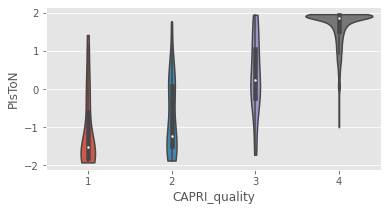

In [69]:

## Violin plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#sns.set_style('whitegrid')
plt.subplots(figsize=(6, 3))

# sns.kdeplot(data=scores_df, x='PIsToN_score', hue='CAPRI_quality', fill=True)
# #sns.despine()
# plt.show()
gfg = sns.violinplot(data=scores_df, x='CAPRI_quality', y='PIsToN', cut=0)
plt.savefig('./figures/violin_2023_PIsToN.png',dpi=600)


PIsToN
dMaSIF
GNN_DOVE


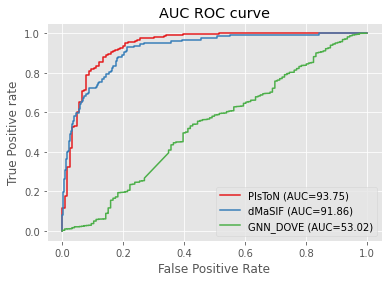

In [70]:
df = scores_df
def plot_ROC(df, score_name, label_name, model_name, ax, color, pos_label):
    fpr, tpr, thresh = roc_curve(df[label_name], df[score_name].fillna(0), pos_label=pos_label)
    AUC = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, linestyle='-',color=color, label=f'{model_name} (AUC={int(AUC*10000)/100})')

    # matplotlib
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

colors = matplotlib.cm.Set1(range(9))

fig, ax = plt.subplots()

other_labels = ['PIsToN', 'dMaSIF', 'GNN_DOVE']
pos_labels = [0,1,0]
colors_array = ['r', 'c', 'm']
for i in range(len(other_labels)):
    print(other_labels[i])
    plot_ROC(df, other_labels[i], 'label', other_labels[i], ax, colors[i], pos_label=pos_labels[i])


# # title
plt.title('AUC ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig(f'figures/AUC_2023_{MODEL_NAME}.png',dpi=600)
plt.show();

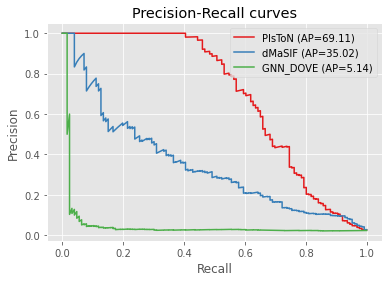

In [71]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

def plot_AUPRC(df, score_name, label_name, model_name, ax, color, reverse_sign=False):
    # Precision-Recall curve
    pred_scores = - df[score_name].fillna(0) if reverse_sign else df[score_name].fillna(0)
    precision, recall, thresholds = precision_recall_curve(df[label_name], pred_scores)
    AP = average_precision_score(df[label_name], pred_scores)
    ax.plot(recall, precision, linestyle='-',color=color, label=f'{model_name} (AP={int(AP*10000)/100})')      

fig, ax = plt.subplots()
other_labels = ['PIsToN','dMaSIF', 'GNN_DOVE']
reverse_sign = [1,0,1]
colors_array = ['r', 'c', 'm', 'y', 'black']
for i in range(len(other_labels)):
    plot_AUPRC(df, other_labels[i], 'label', other_labels[i], ax, colors[i], reverse_sign=reverse_sign[i])


# # title
plt.title('Precision-Recall curves')
# x label
plt.xlabel('Recall')
# y label
plt.ylabel('Precision')

plt.legend(loc='best')
plt.savefig(f'figures/out_2023_AUPRC_{MODEL_NAME}.png',dpi=600)
plt.show();

## Success rate

In [72]:
import numpy as np

all_targets = list(df['PID'].unique())


def compute_success_rate(method, ascending):
    top1 = 0
    top10 = 0
    top25 = 0
    top100= 0
    top200 = 0
    for target in all_targets:
        target_df = df[df['PID']==target]
        target_df = target_df.sort_values(by=method, ascending=ascending).reset_index(drop=True)
        if 1 in list(target_df[:1]['label']):
             top1+=1
        if 1 in list(target_df[:10]['label']):
            top10+=1
        if 1 in list(target_df[:25]['label']):
            top25+=1
        if 1 in list(target_df[:100]['label']):
             top100+=1
        if 1 in list(target_df[:200]['label']):
            top200+=1
    all_success_rate = [top1, top10, top25, top100, top200]
    #all_success_rate = [top10, top25, top200]

    all_success_rate = [int(x*100/len(all_targets)) for x in all_success_rate]
#     print(method)
#     print(all_success_rate)
    #print(f"Top1: {all_success_rate[0]} Top10: {all_success_rate[1]}; Top25: {all_success_rate[[2]]}; Top100: {all_success_rate[3]}; Top200: {all_success_rate[4]}")
    return all_success_rate


#compute_success_rate('PISToN', True)
methods = ['PIsToN', 'dMaSIF', 'GNN_DOVE']
all_scores = []
for method in methods:
    if method=='DeepRank_GNN' or method=='GNN_DOVE' or method=='DOVE' or method=='dMaSIF':
        all_scores.append([method]+compute_success_rate(method, False))
    else:
        all_scores.append([method]+compute_success_rate(method, True))

df_top = pd.DataFrame(all_scores, columns=['model','top1', 'top10', 'top25', 'top100', 'top200'])
df_top


model  top1  top10  top25  top100  top200
0    PIsToN    86     94     98     100     100
1    dMaSIF    50     84     94     100     100
2  GNN_DOVE     3     18     33     100     100

## Classification metrics

In [73]:
all_results = []
all_thresholds = []
all_matthews = []
df = df.dropna()

for i in range(len(methods)):
    print("")
    print(methods[i])
    if methods[i] == 'DeepRank_GNN' or methods[i]=='GNN_DOVE' or methods[i]=='DOVE' or methods[i]=='dMaSIF':
        thresholds, matthews, metrics = find_optimal_threshold(df, methods[i], 'label', reverse_sign=False)
    else:
        thresholds, matthews, metrics = find_optimal_threshold(df, methods[i], 'label', reverse_sign=True)
    all_results.append([other_labels[i]]+metrics)
    all_thresholds.append([other_labels[i]]+thresholds)
    all_matthews.append([other_labels[i]]+matthews)
    
metrics_df = pd.DataFrame(all_results, columns=['Method','BA','F1', 'Precision', 'Recall'])
metrics_df.to_csv('classification_capri_test.csv', index=False)
metrics_df


PIsToN
Optimal threshold: -0.24711723625659943; BA=0.7607451175290372, F1=0.6470588235294118, Precision=0.8461538461538461; Recall=0.5238095238095238

dMaSIF
Optimal threshold: 1.0622229279; BA=0.6749053570661611, F1=0.3665338645418327, Precision=0.368; Recall=0.36507936507936506

GNN_DOVE
Optimal threshold: 0.35837; BA=0.5276274535068505, F1=0.06526806526806525, Precision=0.0462046204620462; Recall=0.1111111111111111


Method        BA        F1  Precision    Recall
0    PIsToN  0.760745  0.647059   0.846154  0.523810
1    dMaSIF  0.674905  0.366534   0.368000  0.365079
2  GNN_DOVE  0.527627  0.065268   0.046205  0.111111